### Visualize W&B results

In [28]:
import pandas as pd
import os
import numpy as np
import json
import matplotlib.pyplot as plt
plt.ioff()  # <- Turn off interactive mode

import matplotlib.gridspec as gridspec

import visualize_functions as vf

import wandb
wandb.login()

True

In [29]:

api = wandb.Api()

# Replace with your actual W&B username and project name
runs = api.runs("simonkral99/Thesis_MTSF")


In [30]:
update_runs = False

if update_runs:
    run_data = []
    for run in runs:
        summary = run.summary._json_dict
        config = {k: v for k, v in run.config.items() if not k.startswith('_')}
        run_data.append({**config, **summary, "run_id": run.id, "name": run.name})
    df = pd.DataFrame(run_data)

    columns_to_keep = ['model', 'pred_len', 'random_seed', 'patience', 'data_path', 'mae', 'mse', 'seq_len', 'conv_kernel_size', 'n_blocks', 'cd_regularization', 'learn_cd_regularization', 
                   'convex', 'sigmoid', 'lambda_freeze_patience', "cd_weight_decay", "mse_train", "mae_train", "mse_train_per_channel_list", "mse_per_channel_list"
                   , "mae_train_per_channel_list", "mae_per_channel_list", "channel_handling", "learning_rate", "batch_size", "head_dropout", "dropout", "delta_factor", "setting_string",
                   "skip_1st_epoch"]
    
    df = df[columns_to_keep].copy()
    df['data_path'] = df['data_path'].str.replace('.csv', '', regex=False)


    df.to_pickle("wandb_runs.pkl")
else:

    df = pd.read_pickle("wandb_runs.pkl")

#print(df.columns)

In [31]:
df['delta_factor'] = df['delta_factor'].fillna(1)
df['skip_1st_epoch'] = df['skip_1st_epoch'].fillna(0)
df_subset = df.copy()

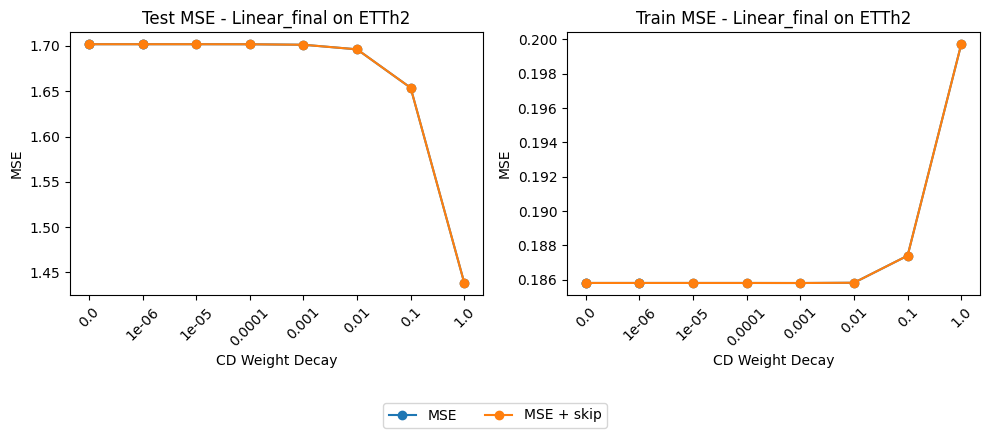

In [32]:
# Shared filter params
data = "ETTh2"
channel_handling = "Delta"
model = "Linear_final"
random_seed = 2021
pred_len = 96
#pred_len = 24
patience = 20
seq_len = 336
#seq_len = 104


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

handles = []
labels = []

for i, (skip, label_suffix) in enumerate([(0, ""), (1, " + skip")]):
    df_filtered = df_subset[
        (df_subset['data_path'].str.contains(data)) &
        (~df_subset['data_path'].str.contains("lag")) &
        (df_subset['model'] == model) &
        (df_subset['channel_handling'] == channel_handling) &
        (df_subset['random_seed'] == random_seed) &
        (df_subset['skip_1st_epoch'] == skip) &
        (df_subset['pred_len'] == pred_len) &
        (df_subset['patience'] == patience) &
        (df_subset['seq_len'] == seq_len)
    ].sort_values(by='cd_weight_decay')

    label = 'MSE' + label_suffix
    line1, = axes[0].plot(df_filtered['cd_weight_decay'].astype(str), df_filtered['mse'], marker='o', label=label)
    line2, = axes[1].plot(df_filtered['cd_weight_decay'].astype(str), df_filtered['mse_train'], marker='o', label=label)

    if label not in labels:  # add only if unique
        handles.append(line1)
        labels.append(label)

# Customize subplots
axes[0].set_title(f'Test MSE - {model} on {data}')
axes[0].set_xlabel('CD Weight Decay')
axes[0].set_ylabel('MSE')
axes[0].tick_params(axis='x', rotation=45)

axes[1].set_title(f'Train MSE - {model} on {data}')
axes[1].set_xlabel('CD Weight Decay')
axes[1].set_ylabel('MSE')
axes[1].tick_params(axis='x', rotation=45)

# Place a single legend below both plots
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # make space for legend
plt.show()


### Results published in papers

In [33]:
paper_results_df = pd.read_csv('../paper_results.csv')
paper_results_df.head()

,Dataset,Prediction Length,MSE,MAE,model,source,ci_cd,model_source
0,ETTm1,96,0.288,0.343,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
1,ETTm1,192,0.326,0.367,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
2,ETTm1,336,0.365,0.391,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
3,ETTm1,720,0.412,0.413,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
4,ETTm1,Avg,0.348,0.379,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)


In [34]:

"""
df_ref = paper_results_df[
    (paper_results_df['source'] == "nie2023_patchtst") #| 
    #(paper_results_df['model'] == "Linear") | (paper_results_df['model'] == "Linear_CI") | (paper_results_df['model'] == "Linear_CD")
    #(paper_results_df['model'] == "Linear_CI") | (paper_results_df['model'] == "Linear_CD")
]
"""
df_ref = paper_results_df.copy()

df_ref.columns = ['data_path', 'pred_len', 'mse', 'mae', 'model', 'source', 'ci_cd', 'model_source']
df_ref = df_ref.replace("ILI", "national_illness")
df_ref = df_ref.replace("Traffic", "traffic")
df_ref = df_ref.replace("Weather", "weather")
df_ref = df_ref.replace("Electricity", "electricity")
df_ref = df_ref.replace("Exchange", "exchange_rate")

df_ref = df_ref.dropna()

color_map = {'CI': 'tab:blue', 'CD': 'tab:orange'}

display(df_ref.head())

,data_path,pred_len,mse,mae,model,source,ci_cd,model_source
0,ETTm1,96,0.288,0.343,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
1,ETTm1,192,0.326,0.367,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
2,ETTm1,336,0.365,0.391,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
3,ETTm1,720,0.412,0.413,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)
4,ETTm1,Avg,0.348,0.379,TVNet,li2025_tvnet,CD,TVNet (li2025_tvnet)


# NEW Shower example (dataset selection)
#### 1 Channel of exisiting dataset + lagged one

## Check Avg error channel-wise = error

In [35]:
import statistics

"""
pred_len_list = [96, 720]
data_path_list = ["ETTh1", "weather"]

decimals = 5

for i, pred_len in enumerate(pred_len_list):
    for j, data_path in enumerate(data_path_list):
        df_CI = df_subset[(df_subset['data_path'].str.contains(data_path)) & (df_subset['pred_len'] == pred_len) & (df_subset["mse_train_per_channel_list"].notna())].copy()
        
        for index, row in df_CI.iterrows():
            print(index, data_path, round(statistics.mean(row['mse_per_channel_list']), decimals), round(statistics.mean(row['mse_train_per_channel_list']), decimals))
            print(index, data_path, round(row['mse'], decimals), round(row['mse_train'], decimals))
            print()
            print(index, data_path, round(statistics.mean(row['mae_per_channel_list']), decimals), round(statistics.mean(row['mae_train_per_channel_list']), decimals))
            print(index, data_path, round(row['mae'], decimals), round(row['mae_train'], decimals))
            print()
            
"""

'\npred_len_list = [96, 720]\ndata_path_list = ["ETTh1", "weather"]\n\ndecimals = 5\n\nfor i, pred_len in enumerate(pred_len_list):\n    for j, data_path in enumerate(data_path_list):\n        df_CI = df_subset[(df_subset[\'data_path\'].str.contains(data_path)) & (df_subset[\'pred_len\'] == pred_len) & (df_subset["mse_train_per_channel_list"].notna())].copy()\n        \n        for index, row in df_CI.iterrows():\n            print(index, data_path, round(statistics.mean(row[\'mse_per_channel_list\']), decimals), round(statistics.mean(row[\'mse_train_per_channel_list\']), decimals))\n            print(index, data_path, round(row[\'mse\'], decimals), round(row[\'mse_train\'], decimals))\n            print()\n            print(index, data_path, round(statistics.mean(row[\'mae_per_channel_list\']), decimals), round(statistics.mean(row[\'mae_train_per_channel_list\']), decimals))\n            print(index, data_path, round(row[\'mae\'], decimals), round(row[\'mae_train\'], decimals))\n     

# Remove duplicates

In [36]:
columns_to_keep = ['model', 'pred_len', 'random_seed', 'data_path', 'mae', 'mse', 'seq_len', "cd_weight_decay", "mse_train", "mae_train", "mse_train_per_channel_list", 
                   "mse_per_channel_list", "mae_train_per_channel_list", "mae_per_channel_list", "channel_handling", "learning_rate", "batch_size", "patience", "head_dropout",
                   "dropout", "delta_factor", "skip_1st_epoch"]

# Keep only those columns
df_subset = df[columns_to_keep]
df_subset['data_path'] = df_subset['data_path'].str.replace('.csv', '', regex=False)

df_subset = df_subset[df_subset['model'].isin(["Linear_final", "ModernTCN", "PatchTST"])]

df_hashable = df_subset.loc[:, df_subset.applymap(type).ne(list).all()]
duplicates = df_hashable[df_hashable.duplicated()]
display(duplicates)

# Remove duplicates from df_subset based on hashable columns
df_subset = df_subset[~df_hashable.duplicated()]

/scratch/ipykernel_491922/4226996381.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['data_path'] = df_subset['data_path'].str.replace('.csv', '', regex=False)
/scratch/ipykernel_491922/4226996381.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hashable = df_subset.loc[:, df_subset.applymap(type).ne(list).all()]


,model,pred_len,random_seed,data_path,mae,mse,seq_len,cd_weight_decay,mse_train,mae_train,channel_handling,learning_rate,batch_size,patience,head_dropout,dropout,delta_factor,skip_1st_epoch
473,PatchTST,96,2021,ETTm2,0.254921,0.164901,336,0.0,0.208256,0.258387,CI_glob,0.0001,128,20,0.0,0.20,1.0,0.0
474,PatchTST,96,2021,ETTm2,0.254921,0.164901,336,0.0,0.208256,0.258387,CI_glob,0.0001,128,20,0.0,0.20,1.0,0.0
533,PatchTST,96,2021,ETTm2,0.251381,0.163358,336,0.0,0.191638,0.250169,CI_loc,0.0001,128,20,0.0,0.20,1.0,0.0
554,PatchTST,96,2021,ETTm2,0.254921,0.164901,336,0.0,0.208256,0.258387,CI_glob,0.0001,128,20,0.0,0.20,1.0,0.0
583,PatchTST,96,2021,weather,0.199393,0.151571,336,0.0,0.405948,0.293351,CI_glob,0.0001,128,20,0.0,0.20,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7636,Linear_final,720,2025,_weather_shower_lag_336_T_degC,0.523172,0.436741,336,0.0,0.385851,0.485130,CI_loc,0.0050,32,20,0.0,0.05,1.0,0.0
7638,Linear_final,96,2025,_weather_shower_lag_336_T_degC,0.210363,0.081089,336,0.0,0.127991,0.260060,CI_glob,0.0050,32,20,0.0,0.05,1.0,0.0
7642,Linear_final,192,2025,_weather_shower_lag_336_T_degC,0.265264,0.129250,336,0.0,0.172968,0.311971,CI_glob,0.0050,32,20,0.0,0.05,1.0,0.0
7644,Linear_final,336,2025,_weather_shower_lag_336_T_degC,0.413366,0.274551,336,0.0,0.274196,0.403406,CI_glob,0.0050,32,20,0.0,0.05,1.0,0.0


# Remove unwanted HPs

In [37]:
# Make a copy of the index to avoid modifying during iteration
rows_to_drop = []

for idx, row in df_subset.iterrows():
    if "lag" in row["data_path"] and row["patience"] == 100:
        rows_to_drop.append(idx)
    
    if row["model"] == "Linear_final":
        if row["channel_handling"] in ["CD", "Delta"] and row["skip_1st_epoch"] == 0 and ("lag" not in row["data_path"]):
            rows_to_drop.append(idx)
        elif row["learning_rate"] != 0.005:
            rows_to_drop.append(idx)
            #print(row.to_string())
        elif row["data_path"] in ["traffic", "electricity"] and (row["batch_size"] != 16 or row["patience"] != 10):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "exchange_rate", "national_illness"] and (row["batch_size"] != 32 or row["patience"] != 20):
            rows_to_drop.append(idx)

    elif row["model"] == "PatchTST":
        if row["data_path"] in ["traffic", "electricity"] and row["patience"] != 10:
            rows_to_drop.append(idx)
            print(row.to_string())
        elif row["data_path"] in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "national_illness", "weather"] and row["patience"] != 20:
            rows_to_drop.append(idx)
            print(row.to_string())
    
    elif row["model"] == "ModernTCN":
        if row["channel_handling"] == "Delta" and row["delta_factor"] != 0.5:
            rows_to_drop.append(idx)
        elif row["data_path"] in ["ETTh1", "ETTh2"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0 or row["dropout"] != 0.3):
            rows_to_drop.append(idx)
            #print(row.to_string())
        #elif row["data_path"] in ["ETTm1", "ETTm2"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0.1 or row["dropout"] != 0.3):
        elif row["data_path"] in ["ETTm1", "ETTm2"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0.0 or row["dropout"] != 0.3):
            rows_to_drop.append(idx)
            print(row.to_string())
        elif row["data_path"] in ["electricity"] and (row["patience"] != 10 or row["batch_size"] != 512 or row["head_dropout"] != 0 or row["dropout"] != 0.9):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["traffic"] and (row["patience"] != 10 or row["batch_size"] != 32 or row["head_dropout"] != 0 or row["dropout"] != 0.9):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["national_illness"] and (row["patience"] != 5 or row["batch_size"] != 32 or row["head_dropout"] != 0 or row["dropout"] != 0.1):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["weather"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0 or row["dropout"] != 0.4):
            rows_to_drop.append(idx)
        elif row["data_path"] in ["exchange_rate"] and (row["patience"] != 20 or row["batch_size"] != 512 or row["head_dropout"] != 0.6 or row["dropout"] != 0.2):
            rows_to_drop.append(idx)


print(f"Dropping {len(rows_to_drop)} rows based on model and hyperparameter conditions.")

dropped_rows_df = df_subset.loc[rows_to_drop]
#display(dropped_rows_df[dropped_rows_df["model"] == "Linear_final"])

# Drop the rows head_dropout
df_subset = df_subset.drop(index=rows_to_drop)

#display(df)
#display(df[(df["model"] == "Linear_final") & (df["data_path"] == "ETTh1")& (df["patience"] == 20)& (df["random_seed"] == 2021)])



model                                                                 ModernTCN
pred_len                                                                     96
random_seed                                                                2021
data_path                                                                 ETTm2
mae                                                                    0.257687
mse                                                                    0.169133
seq_len                                                                     336
cd_weight_decay                                                             0.0
mse_train                                                               0.19823
mae_train                                                              0.257306
mse_train_per_channel_list    [0.30523407459259033, 0.3695241808891296, 0.07...
mse_per_channel_list          [0.27678433060646057, 0.20330683887004852, 0.0...
mae_train_per_channel_list    [0.3430073

# Linear final - channel-wise

In [43]:
df_avg = pd.DataFrame()

"""
loop over:
    - channel_handling
        - cd_weight_decay
            - pred_len
    -> Dafür dann über random seeds avg bilden        

"""


def avg_seeds(df_avg=df_avg, data_path="national_illness", model="Linear_final", df_subset=df_subset):
    list_channel_handling = df_subset['channel_handling'].unique().tolist()

    df_subset = df_subset[
        (df_subset['model'] == model) &
        (df_subset['data_path'] == data_path)

        #(df_subset['data_path'].str.contains(data_path)) &
        #(~df_subset['data_path'].str.contains("lag"))
    ].copy()
        
    for channel_handling in list_channel_handling:
        
        df_seed_channel = df_subset[df_subset['channel_handling'] == channel_handling]
        if df_seed_channel.empty:
            continue

        list_cd_weight_decay = df_seed_channel['cd_weight_decay'].unique().tolist()
        list_cd_pred_len = df_seed_channel['pred_len'].unique().tolist()

        list_cd_pred_len = list_cd_pred_len + ["Avg"]
        
        for cd_weight_decay in list_cd_weight_decay:
            for pred_len in list_cd_pred_len:
                if pred_len == "Avg":
                    df_seed_channel_cd = df_seed_channel[(df_seed_channel['cd_weight_decay'] == cd_weight_decay)].copy()
                else:
                    df_seed_channel_cd = df_seed_channel[(df_seed_channel['cd_weight_decay'] == cd_weight_decay) &
                                                        (df_seed_channel['pred_len'] == pred_len)
                                                        ].copy()
                if df_seed_channel_cd.empty:
                    continue

                avg_row = {
                    'model': model,
                    'data_path': data_path,
                    'pred_len': pred_len,
                    'random_seed': "Avg",

                    'mse_mean': df_seed_channel_cd['mse'].mean(),
                    'mse_std': df_seed_channel_cd['mse'].std(),
                    'mae_mean': df_seed_channel_cd['mae'].mean(),
                    'mae_std': df_seed_channel_cd['mae'].std(),

                    'mse_train_mean': df_seed_channel_cd['mse_train'].mean(),
                    'mse_train_std': df_seed_channel_cd['mse_train'].std(),
                    'mae_train_mean': df_seed_channel_cd['mae_train'].mean(),
                    'mae_train_std': df_seed_channel_cd['mae_train'].std(),

                    'cw_mse_std_mean': df_seed_channel_cd['cw_mse_std'].mean(),
                    'cw_mse_std_std': df_seed_channel_cd['cw_mse_std'].std(),
                    'cw_mae_std_mean': df_seed_channel_cd['cw_mae_std'].mean(),
                    'cw_mae_std_std': df_seed_channel_cd['cw_mae_std'].std(),

                    'cw_mse_train_std_mean': df_seed_channel_cd['cw_mse_train_std'].mean(),
                    'cw_mse_train_std_std': df_seed_channel_cd['cw_mse_train_std'].std(),
                    'cw_mae_train_std_mean': df_seed_channel_cd['cw_mae_train_std'].mean(),
                    'cw_mae_train_std_std': df_seed_channel_cd['cw_mae_train_std'].std(),

                    'cd_weight_decay': cd_weight_decay,
                    'channel_handling': channel_handling,
                    'delta_factor': df_seed_channel_cd['delta_factor'].unique().tolist(),
                    'skip_1st_epoch': df_seed_channel_cd['skip_1st_epoch'].unique().tolist(),
                    'Avg_values_RanS': df_seed_channel_cd['random_seed'].tolist(), 
                    'Avg_Count_RanS': len(df_seed_channel_cd), 
                }
                
                avg_row['mse_per_channel_list_means'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_per_channel_list'].tolist())]
                avg_row['mae_per_channel_list_means'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_per_channel_list'].tolist())]
                avg_row['mse_train_per_channel_list_means'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_train_per_channel_list'].tolist())]
                avg_row['mae_train_per_channel_list_means'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_train_per_channel_list'].tolist())]
                
                avg_row['mse_per_channel_list_stds'] = [np.std(x) for x in zip(*df_seed_channel_cd['mse_per_channel_list'].tolist())]
                avg_row['mae_per_channel_list_stds'] = [np.std(x) for x in zip(*df_seed_channel_cd['mae_per_channel_list'].tolist())]
                avg_row['mse_train_per_channel_list_stds'] = [np.std(x) for x in zip(*df_seed_channel_cd['mse_train_per_channel_list'].tolist())]
                avg_row['mae_train_per_channel_list_stds'] = [np.std(x) for x in zip(*df_seed_channel_cd['mae_train_per_channel_list'].tolist())]

                df_avg = pd.concat([df_avg, pd.DataFrame([avg_row])], ignore_index=True)

    return df_avg

# Example usage

df_avg_seeds = pd.DataFrame()

#["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity", "national_illness"]


# !!!!!!!!!
df_subset = df_subset.dropna()

df_subset = df_subset[~df_subset['data_path'].str.contains('traffic|electricity', case=False, na=False)]
print(df_subset['mse_per_channel_list'].apply(type).value_counts())
print(df_subset[df_subset['mse_per_channel_list'].apply(lambda x: isinstance(x, dict))]['data_path'])


df_subset['cw_mse_std'] = df_subset['mse_per_channel_list'].apply(np.std)
df_subset['cw_mae_std'] = df_subset['mae_per_channel_list'].apply(np.std)
df_subset['cw_mse_train_std'] = df_subset['mse_train_per_channel_list'].apply(np.std)
df_subset['cw_mae_train_std'] = df_subset['mae_train_per_channel_list'].apply(np.std)



list_lag = ["_weather_shower_lag_0_T_degC", "_weather_shower_lag_48_T_degC", "_weather_shower_lag_96_T_degC", "_weather_shower_lag_192_T_degC", 
            "_weather_shower_lag_336_T_degC", "_weather_shower_lag_720_T_degC"]
""" 
for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "exchange_rate", "national_illness"]:
    for model in ["Linear_final", "PatchTST", "ModernTCN"]:
        df_avg_seeds = avg_seeds(df_avg=df_avg_seeds, data_path=data_path, model=model, df_subset=df_subset)

df_avg_seeds.to_pickle("df_avg_seeds.pkl")

#display(df_avg_seeds)
"""

for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "exchange_rate", "national_illness"]:
    for model in ["Linear_final", "PatchTST", "ModernTCN"]:
#for data_path in list_lag:
    #df_avg = pd.DataFrame()
        df_avg = avg_seeds(df_avg, data_path=data_path, model=model, df_subset=df_subset)
        print(df_avg['Avg_Count_RanS'].unique().tolist())

    
#df_avg = avg_seeds(df_avg, data_path="exchange_rate", model="Linear_final", df_subset=df_subset)

# Alles da für Linear, normale Datensätze
"""
df_avg = pd.DataFrame()
df_avg = avg_seeds(df_avg, data_path="_weather_shower_lag_336_T_degC", model="Linear_final", df_subset=df_subset)

display(df_avg)
"""


mse_per_channel_list
<class 'list'>    4499
Name: count, dtype: int64
Series([], Name: data_path, dtype: object)
[5, 20]
[5, 20]
[5, 20]
[5, 20]
[5, 20]
[5, 20]


[5, 20]
[5, 20]
[5, 20]
[5, 20]
[5, 20]
[5, 20, 4, 3, 15, 14]
[5, 20, 4, 3, 15, 14]
[5, 20, 4, 3, 15, 14]
[5, 20, 4, 3, 15, 14]
[5, 20, 4, 3, 15, 14]
[5, 20, 4, 3, 15, 14]
[5, 20, 4, 3, 15, 14]
[5, 20, 4, 3, 15, 14]
[5, 20, 4, 3, 15, 14]
[5, 20, 4, 3, 15, 14]


'\ndf_avg = pd.DataFrame()\ndf_avg = avg_seeds(df_avg, data_path="_weather_shower_lag_336_T_degC", model="Linear_final", df_subset=df_subset)\n\ndisplay(df_avg)\n'

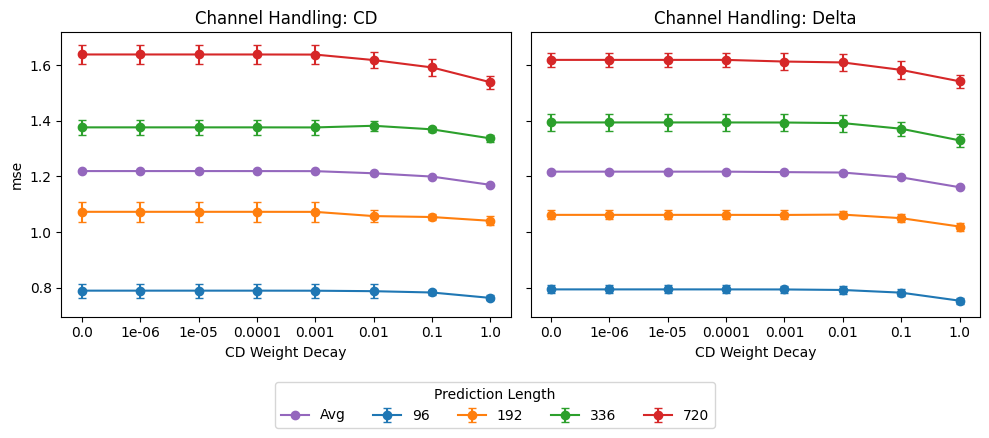

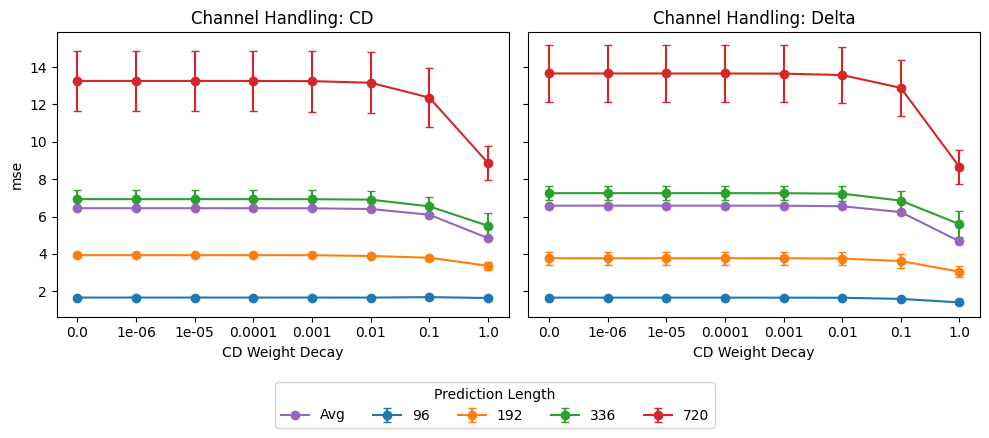

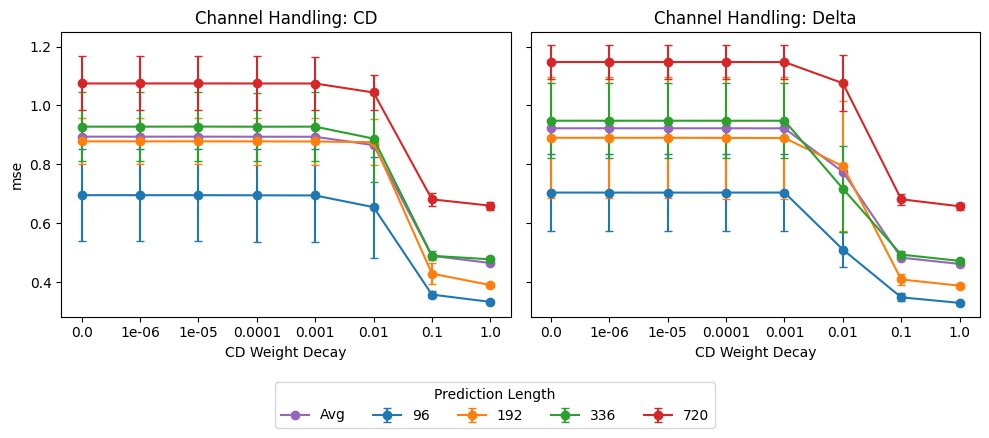

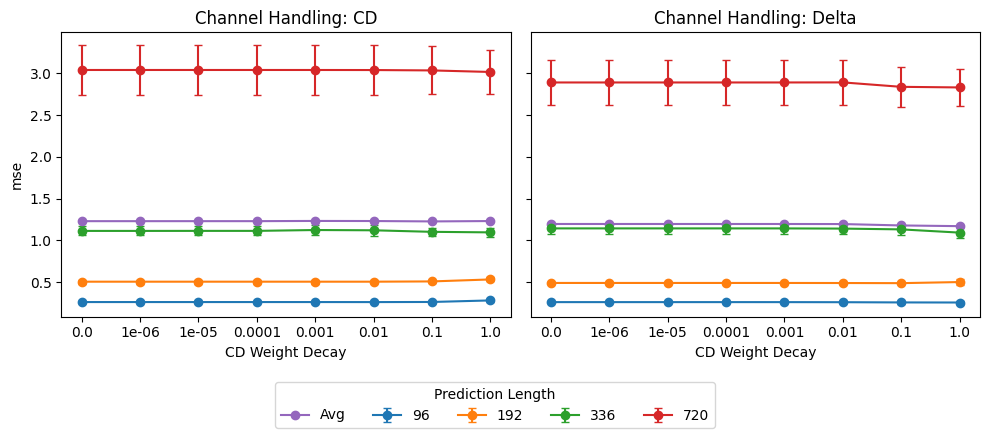

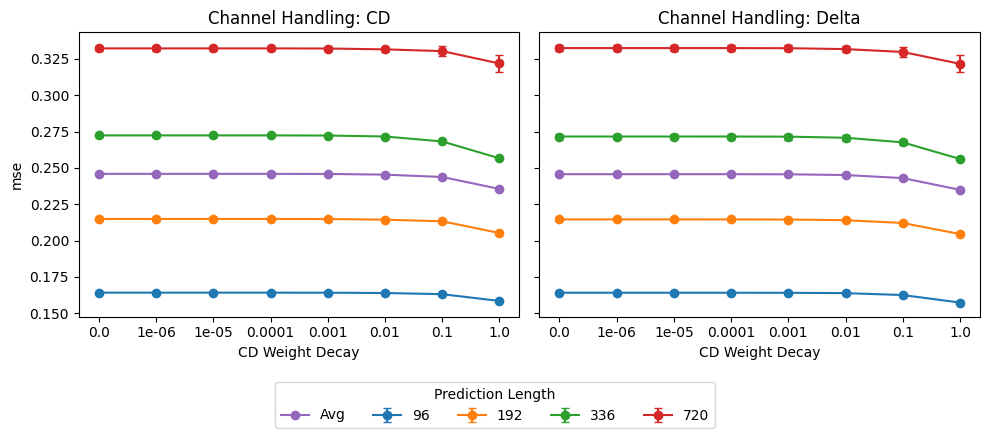

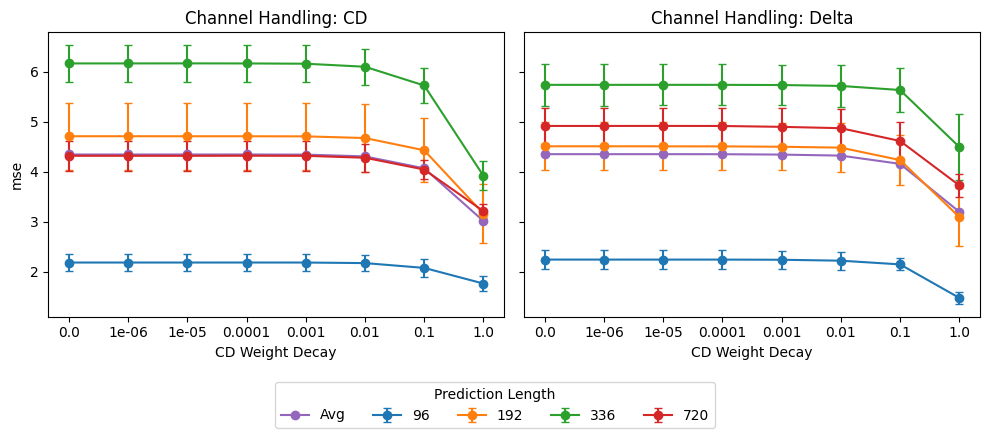

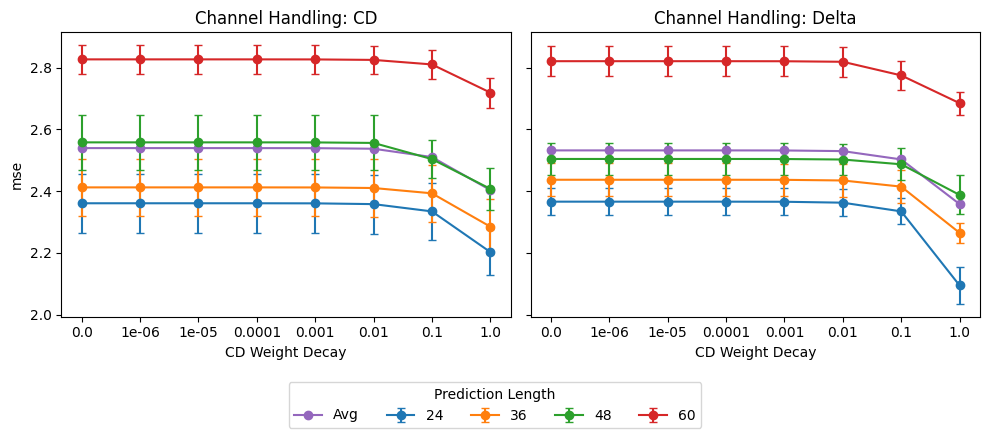

In [77]:
metric = "mse"
data = "ETTh1"
model = "Linear_final"
channel_handlings = ["CD", "Delta"]
pred_lens = [96, 192, 336, 720, "Avg"]

for data in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "exchange_rate", "national_illness"]:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    pred_lens = df_avg[(df_avg['data_path'] == data)]['pred_len'].unique().tolist()
    pred_lens = sorted(pred_lens, key=lambda x: float('inf') if x == "Avg" else x)

    #print(pred_lens)

    for ax, channel_handling in zip(axes, channel_handlings):
        for pred_len in pred_lens:
            df_filtered = df_avg[
                (df_avg['data_path'] == data) &
                (df_avg['model'] == model) &
                (df_avg['channel_handling'] == channel_handling) &
                (df_avg['pred_len'] == pred_len)
            ].sort_values(by='cd_weight_decay')

            if not df_filtered.empty:
                if pred_len == "Avg":
                    ax.plot(
                        df_filtered['cd_weight_decay'].astype(str),
                        df_filtered[metric+'_mean'],
                        marker='o',
                        label=str(pred_len)
                    )
                else:
                    ax.errorbar(
                        df_filtered['cd_weight_decay'].astype(str),
                        df_filtered[metric+'_mean'],
                        yerr=df_filtered[metric+'_std'],
                        marker='o',
                        capsize=3,
                        label=str(pred_len)
                    )

        ax.set_title(f"Channel Handling: {channel_handling}")
        ax.set_xlabel("CD Weight Decay")
        #ax.grid()

    axes[0].set_ylabel(metric)
    #fig.legend(title="Prediction Length", loc="lower center", ncol=5, bbox_to_anchor=(0.5, -0.1))
    # Get all handles and labels from both axes
    handles_labels = [ax.get_legend_handles_labels() for ax in axes]
    handles, labels = zip(*handles_labels)

    # Flatten and deduplicate
    flat_handles = sum(handles, [])
    flat_labels = sum(labels, [])
    unique = dict(zip(flat_labels, flat_handles))  # removes duplicates by label

    # Shared legend
    fig.legend(
        unique.values(),
        unique.keys(),
        title="Prediction Length",
        loc="lower center",
        ncol=5,
        bbox_to_anchor=(0.5, -0.1)
    )
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()


In [ ]:
"""

def avg_seeds(df_avg=df_avg, data_path="national_illness", model="Linear_final", df_subset=df_subset):
    list_channel_handling = df_subset['channel_handling'].unique().tolist()
    random_seeds = df_subset['random_seed'].unique().tolist()

    df_subset = df_subset[
        (df_subset['model'] == model) &
        (df_subset['data_path'] == data_path)

        #(df_subset['data_path'].str.contains(data_path)) &
        #(~df_subset['data_path'].str.contains("lag"))
    ].copy()
        
    for channel_handling in list_channel_handling:
        df_seed_channel = df_subset[df_subset['channel_handling'] == channel_handling]
        if df_seed_channel.empty:
            continue

        list_cd_weight_decay = df_seed_channel['cd_weight_decay'].unique().tolist()
        list_cd_pred_len = df_seed_channel['pred_len'].unique().tolist()
        
        for cd_weight_decay in list_cd_weight_decay:
            for pred_len in list_cd_pred_len:
                df_seed_channel_cd = df_seed_channel[(df_seed_channel['cd_weight_decay'] == cd_weight_decay) &
                                                     (df_seed_channel['pred_len'] == pred_len)
                                                     ].copy()
                if df_seed_channel_cd.empty:
                    continue

                avg_row = {
                    'model': model,
                    'data_path': data_path,
                    'pred_len': pred_len,
                    'random_seed': "Avg",
                    'mse': df_seed_channel_cd['mse'].mean(),
                    'mae': df_seed_channel_cd['mae'].mean(),
                    'mse_train': df_seed_channel_cd['mse_train'].mean(),
                    'mae_train': df_seed_channel_cd['mae_train'].mean(),
                    'cd_weight_decay': cd_weight_decay,
                    'channel_handling': channel_handling,
                    'Avg_values_RanS': df_seed_channel_cd['random_seed'].tolist(), 
                    'Avg_Count_RanS': len(df_seed_channel_cd), 
                }

                avg_row['mse_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_per_channel_list'].tolist())]
                avg_row['mae_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_per_channel_list'].tolist())]
                avg_row['mse_train_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_train_per_channel_list'].tolist())]
                avg_row['mae_train_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_train_per_channel_list'].tolist())]

                avg_row['mse_per_channel_std'] = np.std(avg_row['mse_per_channel_list'])
                avg_row['mae_per_channel_std'] = np.std(avg_row['mae_per_channel_list'])
                avg_row['mse_train_per_channel_std'] = np.std(avg_row['mse_train_per_channel_list'])
                avg_row['mae_train_per_channel_std'] = np.std(avg_row['mae_train_per_channel_list'])

                df_avg = pd.concat([df_avg, pd.DataFrame([avg_row])], ignore_index=True)

    return df_avg

"""

In [12]:
df_avg = pd.DataFrame()

def calc_avg(df_avg=df_avg, data_path="national_illness", model="Linear_final", df_subset=df_subset):
    random_seeds = df_subset['random_seed'].unique().tolist()
    list_channel_handling = df_subset['channel_handling'].unique().tolist()

    for random_seed in random_seeds:
        df_seed = df_subset[
            (df_subset['model'] == model) &
            (df_subset['data_path'].str.contains(data_path)) &
            (df_subset['random_seed'] == random_seed)
        ].copy()

        if df_seed.empty:
            continue
        
        for channel_handling in list_channel_handling:
            df_seed_channel = df_seed[df_seed['channel_handling'] == channel_handling]
            if df_seed_channel.empty:
                continue

            list_cd_weight_decay = df_seed_channel['cd_weight_decay'].unique().tolist()
            
            for cd_weight_decay in list_cd_weight_decay:
                df_seed_channel_cd = df_seed_channel[df_seed_channel['cd_weight_decay'] == cd_weight_decay]
                if df_seed_channel_cd.empty:
                    continue

                # Calculate average values for each channel handling and cd_weight_decay
                avg_row = {
                    'model': model,
                    'data_path': data_path,
                    'pred_len': "Avg",
                    'random_seed': random_seed,
                    'mse': df_seed_channel_cd['mse'].mean(),
                    'mae': df_seed_channel_cd['mae'].mean(),
                    'mse_train': df_seed_channel_cd['mse_train'].mean(),
                    'mae_train': df_seed_channel_cd['mae_train'].mean(),
                    'cd_weight_decay': cd_weight_decay,
                    'channel_handling': channel_handling,
                    'Avg_values_Len': df_seed_channel_cd['pred_len'].tolist(), 
                    'Avg_Count_Len': len(df_seed_channel_cd),
                }

                # Add per channel averages
                avg_row['mse_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_per_channel_list'].tolist())]
                avg_row['mae_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_per_channel_list'].tolist())]
                avg_row['mse_train_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mse_train_per_channel_list'].tolist())]
                avg_row['mae_train_per_channel_list'] = [np.mean(x) for x in zip(*df_seed_channel_cd['mae_train_per_channel_list'].tolist())]

                df_avg = pd.concat([df_avg, pd.DataFrame([avg_row])], ignore_index=True)

    return df_avg

In [13]:
#df_avg = avg_seeds(df_avg, data_path="ETTh1", model="Linear_final", df_subset=df_subset)

df_temp=avg_seeds(df_avg, data_path="ETTh1", model="Linear_final", df_subset=df_subset)

display(df_temp)

df_avg=calc_avg(df_subset=df_temp, data_path="ETTh1")

display(df_avg)

,model,data_path,pred_len,random_seed,mse,mae,mse_train,mae_train,cd_weight_decay,channel_handling,Avg_values_RanS,Avg_Count_RanS,mse_per_channel_list,mae_per_channel_list,mse_train_per_channel_list,mae_train_per_channel_list,mse_per_channel_std,mae_per_channel_std,mse_train_per_channel_std,mae_train_per_channel_std
0,Linear_final,ETTh1,192,Avg,0.428359,0.440656,0.399685,0.448193,0.0,CI_glob,"[2021, 2022, 2023, 2024, 2025]",5,"[0.8228135108947754, 0.24596365988254548, 0.84...","[0.6180592536926269, 0.37087311744689944, 0.61...","[0.3743897438049316, 0.33937657475471494, 0.35...","[0.43477101922035216, 0.44806575775146484, 0.4...",0.286809,0.129172,0.151324,0.074316
1,Linear_final,ETTh1,336,Avg,0.463995,0.465188,0.450571,0.477851,0.0,CI_glob,"[2021, 2022, 2023, 2024, 2025]",5,"[0.8598625302314759, 0.26672130823135376, 0.87...","[0.6311773777008056, 0.3863368630409241, 0.619...","[0.4001357972621918, 0.4042706310749054, 0.375...","[0.45197939276695254, 0.48968377709388733, 0.4...",0.290877,0.124089,0.167571,0.078562
2,Linear_final,ETTh1,720,Avg,0.515326,0.520389,0.526693,0.527229,0.0,CI_glob,"[2021, 2022, 2023, 2024, 2025]",5,"[0.7985777378082275, 0.32062711119651793, 0.78...","[0.6383005142211914, 0.4306677281856537, 0.613...","[0.44845019578933715, 0.5310478210449219, 0.42...","[0.4859287977218628, 0.569275414943695, 0.4603...",0.253390,0.121251,0.171745,0.080721
3,Linear_final,ETTh1,96,Avg,0.385369,0.409559,0.341039,0.409464,0.0,CI_glob,"[2022, 2023, 2024, 2025, 2021]",5,"[0.7591026425361633, 0.215773868560791, 0.7838...","[0.5926631808280944, 0.3466036140918732, 0.589...","[0.3399273455142975, 0.2814298808574677, 0.327...","[0.4073494911193848, 0.4035177230834961, 0.384...",0.275040,0.136664,0.136609,0.073461
4,Linear_final,ETTh1,192,Avg,0.417011,0.423135,0.360720,0.421799,0.0,CI_loc,"[2021, 2022, 2023, 2024, 2025]",5,"[0.8213740110397338, 0.23563361465930938, 0.85...","[0.6121840834617615, 0.362093585729599, 0.6035...","[0.34504504799842833, 0.3095886170864105, 0.32...","[0.4145541787147522, 0.42044357061386106, 0.38...",0.304433,0.148803,0.149545,0.080777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,Linear_final,ETTh1,720,Avg,1.583475,0.992256,0.311273,0.413806,0.1,Delta,"[2021, 2022, 2023, 2024, 2025]",5,"[1.5183112382888795, 2.490428829193115, 1.2193...","[0.9597937583923339, 1.4206832885742187, 0.817...","[0.296810919046402, 0.22764256298542024, 0.281...","[0.40933489203453066, 0.3711067736148834, 0.38...",0.892148,0.377654,0.140348,0.088991
68,Linear_final,ETTh1,96,Avg,0.752832,0.643104,0.245471,0.353476,1.0,Delta,"[2021, 2022, 2023, 2024, 2025]",5,"[1.030314064025879, 0.7746048688888549, 0.9122...","[0.7661731362342834, 0.737368381023407, 0.6853...","[0.26201437711715697, 0.1883576273918152, 0.25...","[0.3664973139762878, 0.33133687973022463, 0.34...",0.460346,0.229054,0.112217,0.075988
69,Linear_final,ETTh1,192,Avg,1.019695,0.769982,0.277994,0.381682,1.0,Delta,"[2021, 2022, 2023, 2024, 2025]",5,"[1.2231001615524293, 1.173753309249878, 1.0237...","[0.8531947016716004, 0.9328744411468506, 0.735...","[0.28317307233810424, 0.2100861370563507, 0.27...","[0.3888586699962616, 0.3522141695022583, 0.367...",0.635145,0.285019,0.125301,0.080499
70,Linear_final,ETTh1,336,Avg,1.329889,0.894243,0.304513,0.403891,1.0,Delta,"[2021, 2022, 2023, 2024, 2025]",5,"[1.2270315408706665, 2.0560516357421874, 1.020...","[0.8429360628128052, 1.2656689167022706, 0.715...","[0.30027305483818056, 0.22388429343700408, 0.2...","[0.40596181750297544, 0.36686198115348817, 0.3...",0.776550,0.348198,0.138109,0.087100


,model,data_path,pred_len,random_seed,mse,mae,mse_train,mae_train,cd_weight_decay,channel_handling,Avg_values_Len,Avg_Count_Len,mse_per_channel_list,mae_per_channel_list,mse_train_per_channel_list,mae_train_per_channel_list
0,Linear_final,ETTh1,Avg,Avg,0.448262,0.458948,0.429497,0.465684,0.000000,CI_glob,"[192, 336, 720, 96]",4,"[0.8100891053676604, 0.26227148696780206, 0.82...","[0.6200500816106795, 0.38362033069133755, 0.60...","[0.39072577059268954, 0.3890312269330025, 0.37...","[0.44500717520713806, 0.47763566821813586, 0.4..."
1,Linear_final,ETTh1,Avg,Avg,0.434888,0.439295,0.389316,0.439849,0.000000,CI_loc,"[192, 336, 720, 96]",4,"[0.8146604299545288, 0.2432438708841801, 0.834...","[0.6163593322038651, 0.36726811230182643, 0.60...","[0.3615326747298241, 0.3566624402999877, 0.336...","[0.4270815163850784, 0.4508898466825485, 0.397..."
2,Linear_final,ETTh1,Avg,Avg,1.219112,0.842110,0.286107,0.394715,0.001000,CD,"[96, 192, 336, 720]",4,"[1.2901591390371323, 1.6741781443357466, 1.086...","[0.8686036676168443, 1.099545058608055, 0.7576...","[0.28928483128547666, 0.21601167991757392, 0.2...","[0.40202566087245944, 0.3603440269827842, 0.38..."
3,Linear_final,ETTh1,Avg,Avg,1.219382,0.842208,0.286074,0.394713,0.000000,CD,"[96, 192, 336, 720]",4,"[1.2904113799333572, 1.674470579624176, 1.0866...","[0.868714416027069, 1.0996017664670945, 0.7578...","[0.28925224021077156, 0.21598700433969498, 0.2...","[0.402025505900383, 0.36033276170492173, 0.384..."
4,Linear_final,ETTh1,Avg,Avg,1.219382,0.842208,0.286074,0.394713,0.000001,CD,"[96, 192, 336, 720]",4,"[1.2904113799333572, 1.674470579624176, 1.0866...","[0.868714416027069, 1.0996017664670945, 0.7578...","[0.28925224021077156, 0.21598700433969498, 0.2...","[0.402025505900383, 0.36033276170492173, 0.384..."
5,Linear_final,ETTh1,Avg,Avg,1.219380,0.842207,0.286074,0.394713,0.000010,CD,"[96, 192, 336, 720]",4,"[1.2904104202985764, 1.6744694143533705, 1.086...","[0.8687138795852661, 1.0996015518903732, 0.757...","[0.289252333343029, 0.21598707288503646, 0.276...","[0.4020254835486412, 0.3603327751159668, 0.384..."
6,Linear_final,ETTh1,Avg,Avg,1.219352,0.842197,0.286078,0.394713,0.000100,CD,"[96, 192, 336, 720]",4,"[1.290383416414261, 1.6744389981031418, 1.0866...","[0.8687022268772125, 1.0995957881212235, 0.757...","[0.2892558015882969, 0.2159896932542324, 0.276...","[0.40202549248933794, 0.3603340104222298, 0.38..."
7,Linear_final,ETTh1,Avg,Avg,1.211459,0.840047,0.278261,0.388123,0.010000,CD,"[96, 192, 336, 720]",4,"[1.278135856986046, 1.6712544441223145, 1.0754...","[0.8657737791538238, 1.1009973168373106, 0.754...","[0.28057807460427286, 0.2086713634431362, 0.26...","[0.3946781948208809, 0.35370442569255833, 0.37..."
8,Linear_final,ETTh1,Avg,Avg,1.199591,0.836564,0.274333,0.382803,0.100000,CD,"[96, 192, 336, 720]",4,"[1.268747013807297, 1.6567543119192125, 1.0600...","[0.8630646109580995, 1.1005895555019378, 0.746...","[0.27620493322610856, 0.20438677892088888, 0.2...","[0.38880622088909145, 0.3492468148469925, 0.36..."
9,Linear_final,ETTh1,Avg,Avg,1.169888,0.826988,0.289041,0.390726,1.000000,CD,"[96, 192, 336, 720]",4,"[1.2300093472003937, 1.6358801901340485, 1.025...","[0.8510730266571045, 1.0981731832027435, 0.733...","[0.29058950394392014, 0.21518780663609505, 0.2...","[0.39595191180706024, 0.3572263568639755, 0.37..."


In [14]:
plt.close('all')

list_model = ["Linear_final", "ModernTCN", "PatchTST"]

df_subset = df_subset.dropna(subset=["mse_per_channel_list"])
df_avg = pd.DataFrame()

#for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity", "national_illness"]:

for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]:
#for data_path in ["ETTh1"]:
    if data_path == "national_illness":
        list_pred_len = [24, 36, 48, 60, "Avg"]
    else:
        list_pred_len = [96, 192, 336, 720, "Avg"]

    for model in list_model:
        if data_path != "traffic" and data_path != "electricity":
            #df_avg = vf.calc_avg(df_avg=df_avg, data_path=data_path, model=model, df_subset=df_subset)
            df_avg = vf.calc_avg(df_avg=df_avg, data_path=data_path, model=model, df_subset=df_avg_seeds)

            #df_avg = calc_avg(df_avg=df_avg, data_path=data_path, model=model, df_subset=df_subset)

        try:
            vf.channel_wise(pred_len="Avg", data_path=data_path, model=model, df_subset=df_avg, show=False);
            #channel_wise(pred_len="Avg", data_path=data_path, model=model, df_subset=df_avg);
        except Exception as e:
            print(f"CW - Error with data_path={data_path}, model={model}, pred_len=Avg: {e}");

        try:    
            vf.channel_handling(pred_len="Avg", data_path=data_path, model=model, df_subset=df_avg, show=False);
            #channel_handling(pred_len="Avg", data_path=data_path, model=model, df_subset=df_avg);
        except Exception as e:
            print(f"CH - Error with data_path={data_path}, model={model}, pred_len=Avg: {e}");

        for pred_len in list_pred_len:
            try:
                #vf.channel_wise(df_subset=df_subset, pred_len=pred_len, data_path=data_path, model=model, show=False);
                vf.channel_wise(df_subset=df_avg_seeds, pred_len=pred_len, data_path=data_path, model=model, show=False);
                #channel_wise(pred_len=pred_len, data_path=data_path, model=model);
            except Exception as e:
                print(f"CW - Error with data_path={data_path}, model={model}, pred_len={pred_len}: {e}");

            try:    
                #vf.channel_handling(df_subset=df_subset, pred_len=pred_len, data_path=data_path, model=model, show=False);
                vf.channel_handling(df_subset=df_avg_seeds, pred_len=pred_len, data_path=data_path, model=model, show=False);
                #channel_handling(pred_len=pred_len, data_path=data_path, model=model);
            except Exception as e:
                print(f"CH - Error with data_path={data_path}, model={model}, pred_len={pred_len}: {e}");

    df_avg["model_CH"] = df_avg["model"] + "_" + df_avg["channel_handling"]

df_avg.to_pickle("df_avg.pkl")

"""
list_pred_len = [96, 192, 336, 720]
list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity"]

for pred_len in list_pred_len:
    for data_path in list_data_path:
        for model in list_model:
            try:
                channel_wise(pred_len=pred_len, data_path=data_path, model=model)
            except Exception as e:
                print(f"CW - Error with data_path={data_path}, model={model}, pred_len={pred_len}: {e}")

            try:    
                channel_handling(pred_len=pred_len, data_path=data_path, model=model)
            except Exception as e:
                print(f"CH - Error with data_path={data_path}, model={model}, pred_len={pred_len}: {e}")


"Avg"
list_data_path = ["national_illness", "ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity"]

display(df_avg)

"""

plt.close('all')

CW - Error with data_path=ETTh1, model=Linear_final, pred_len=Avg: list index out of range
CH - Error with data_path=ETTh1, model=Linear_final, pred_len=Avg: zero-size array to reduction operation maximum which has no identity
CW - Error with data_path=ETTh1, model=ModernTCN, pred_len=Avg: list index out of range
CH - Error with data_path=ETTh1, model=ModernTCN, pred_len=Avg: zero-size array to reduction operation maximum which has no identity
CW - Error with data_path=ETTh1, model=PatchTST, pred_len=Avg: list index out of range
CH - Error with data_path=ETTh1, model=PatchTST, pred_len=Avg: zero-size array to reduction operation maximum which has no identity
CW - Error with data_path=ETTh2, model=Linear_final, pred_len=Avg: list index out of range
CH - Error with data_path=ETTh2, model=Linear_final, pred_len=Avg: zero-size array to reduction operation maximum which has no identity
CW - Error with data_path=ETTh2, model=ModernTCN, pred_len=Avg: list index out of range
CH - Error with da

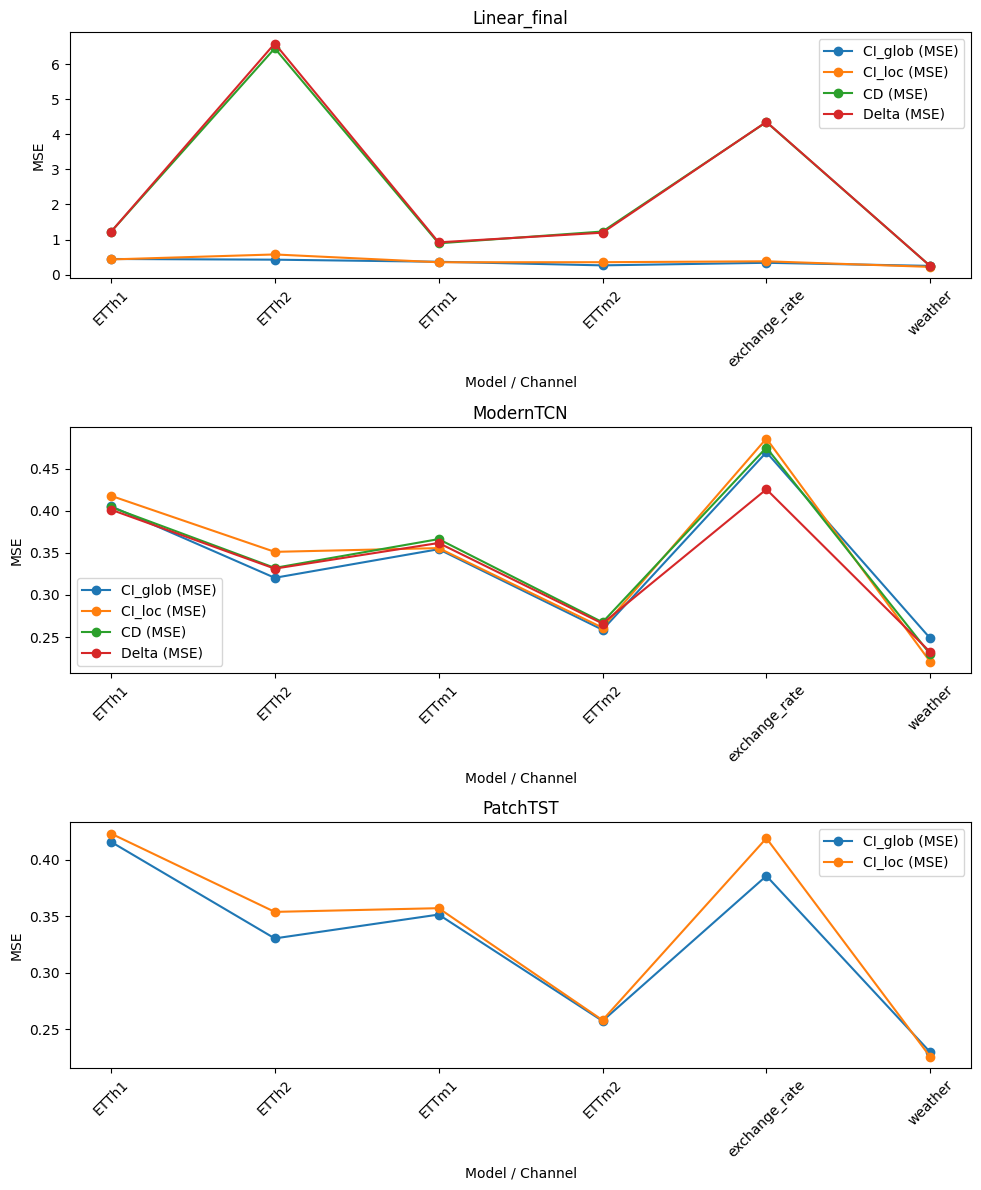

In [15]:
df_avg.head()


data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]
data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather"]

model_list = ["Linear_final", "ModernTCN", "PatchTST"] 

n = len(model_list)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)  # single column, multiple rows

for idx, model in enumerate(model_list):
    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["model"] == model) &
                     (df_avg["cd_weight_decay"] == 0.0) &
                     (df_avg["data_path"].isin(data_path_list))].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue
    
    for channel_handling in df_plot['channel_handling'].unique():
        df_channel = df_plot[df_plot['channel_handling'] == channel_handling]
        ax.plot(df_channel['data_path'], df_channel['mse'], label=channel_handling + " (MSE)", marker='o')
        #ax.plot(df_channel['data_path'], df_channel['mse_train'], label=channel_handling + " (MSE train)", marker='x')
    
    ax.set_title(model)
    ax.legend()
    ax.set_xlabel('Model / Channel')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/Other/models_test.png")
plt.show()


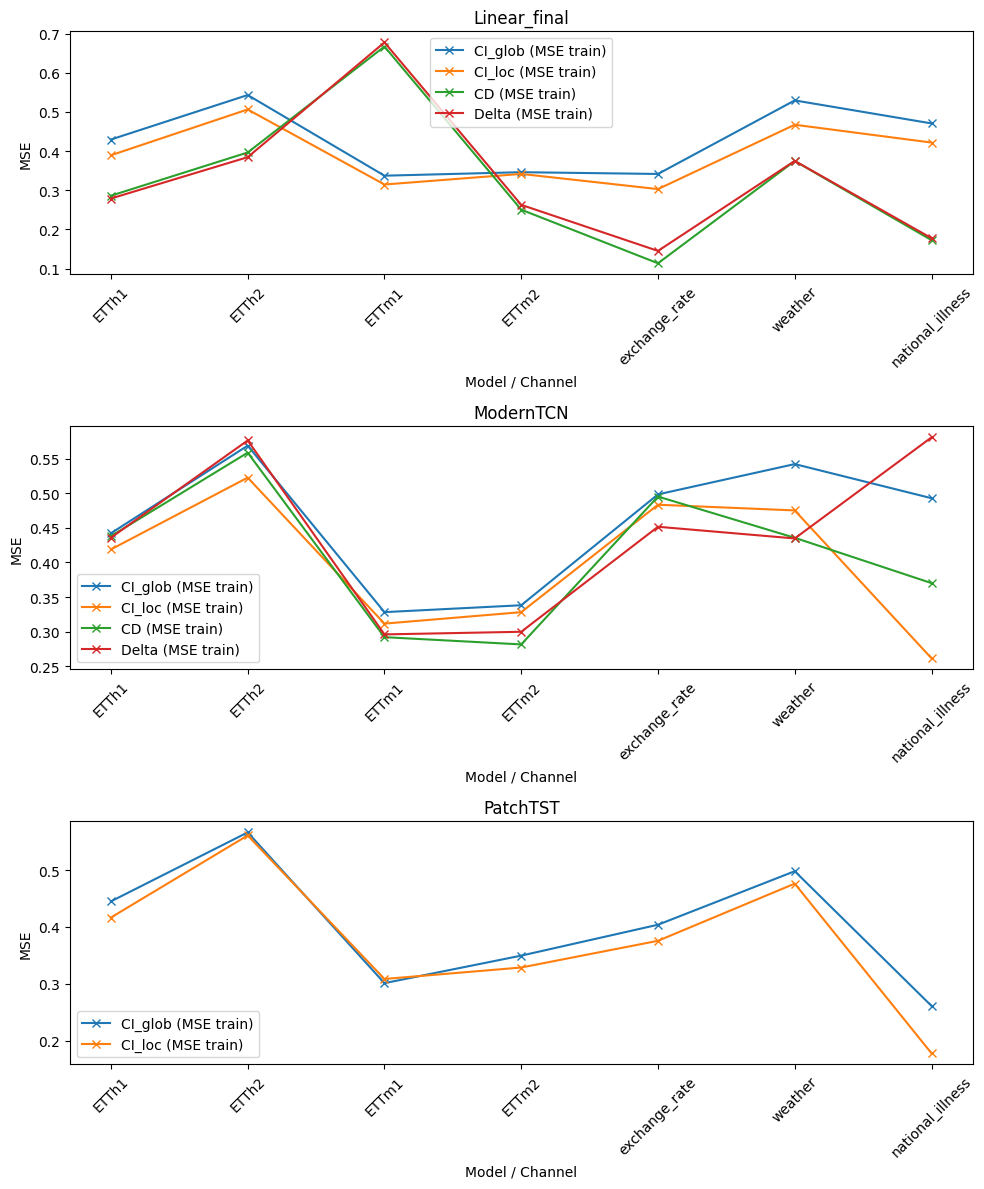

In [16]:
df_avg.head()


data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]

model_list = ["Linear_final", "ModernTCN", "PatchTST"] 

n = len(model_list)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)  # single column, multiple rows

for idx, model in enumerate(model_list):
    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["model"] == model) &
                     (df_avg["cd_weight_decay"] == 0.0) &
                     (df_avg["data_path"].isin(data_path_list))].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue
    
    
    for channel_handling in df_plot['channel_handling'].unique():
        df_channel = df_plot[df_plot['channel_handling'] == channel_handling]
        #ax.plot(df_channel['data_path'], df_channel['mse'], label=channel_handling + " (MSE)", marker='o')
        ax.plot(df_channel['data_path'], df_channel['mse_train'], label=channel_handling + " (MSE train)", marker='x')
    
    ax.set_title(model)
    ax.legend()
    ax.set_xlabel('Model / Channel')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/Other/models_train.png")
plt.show()


/scratch/ipykernel_823259/3122857556.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, linestyle='-', marker='o')


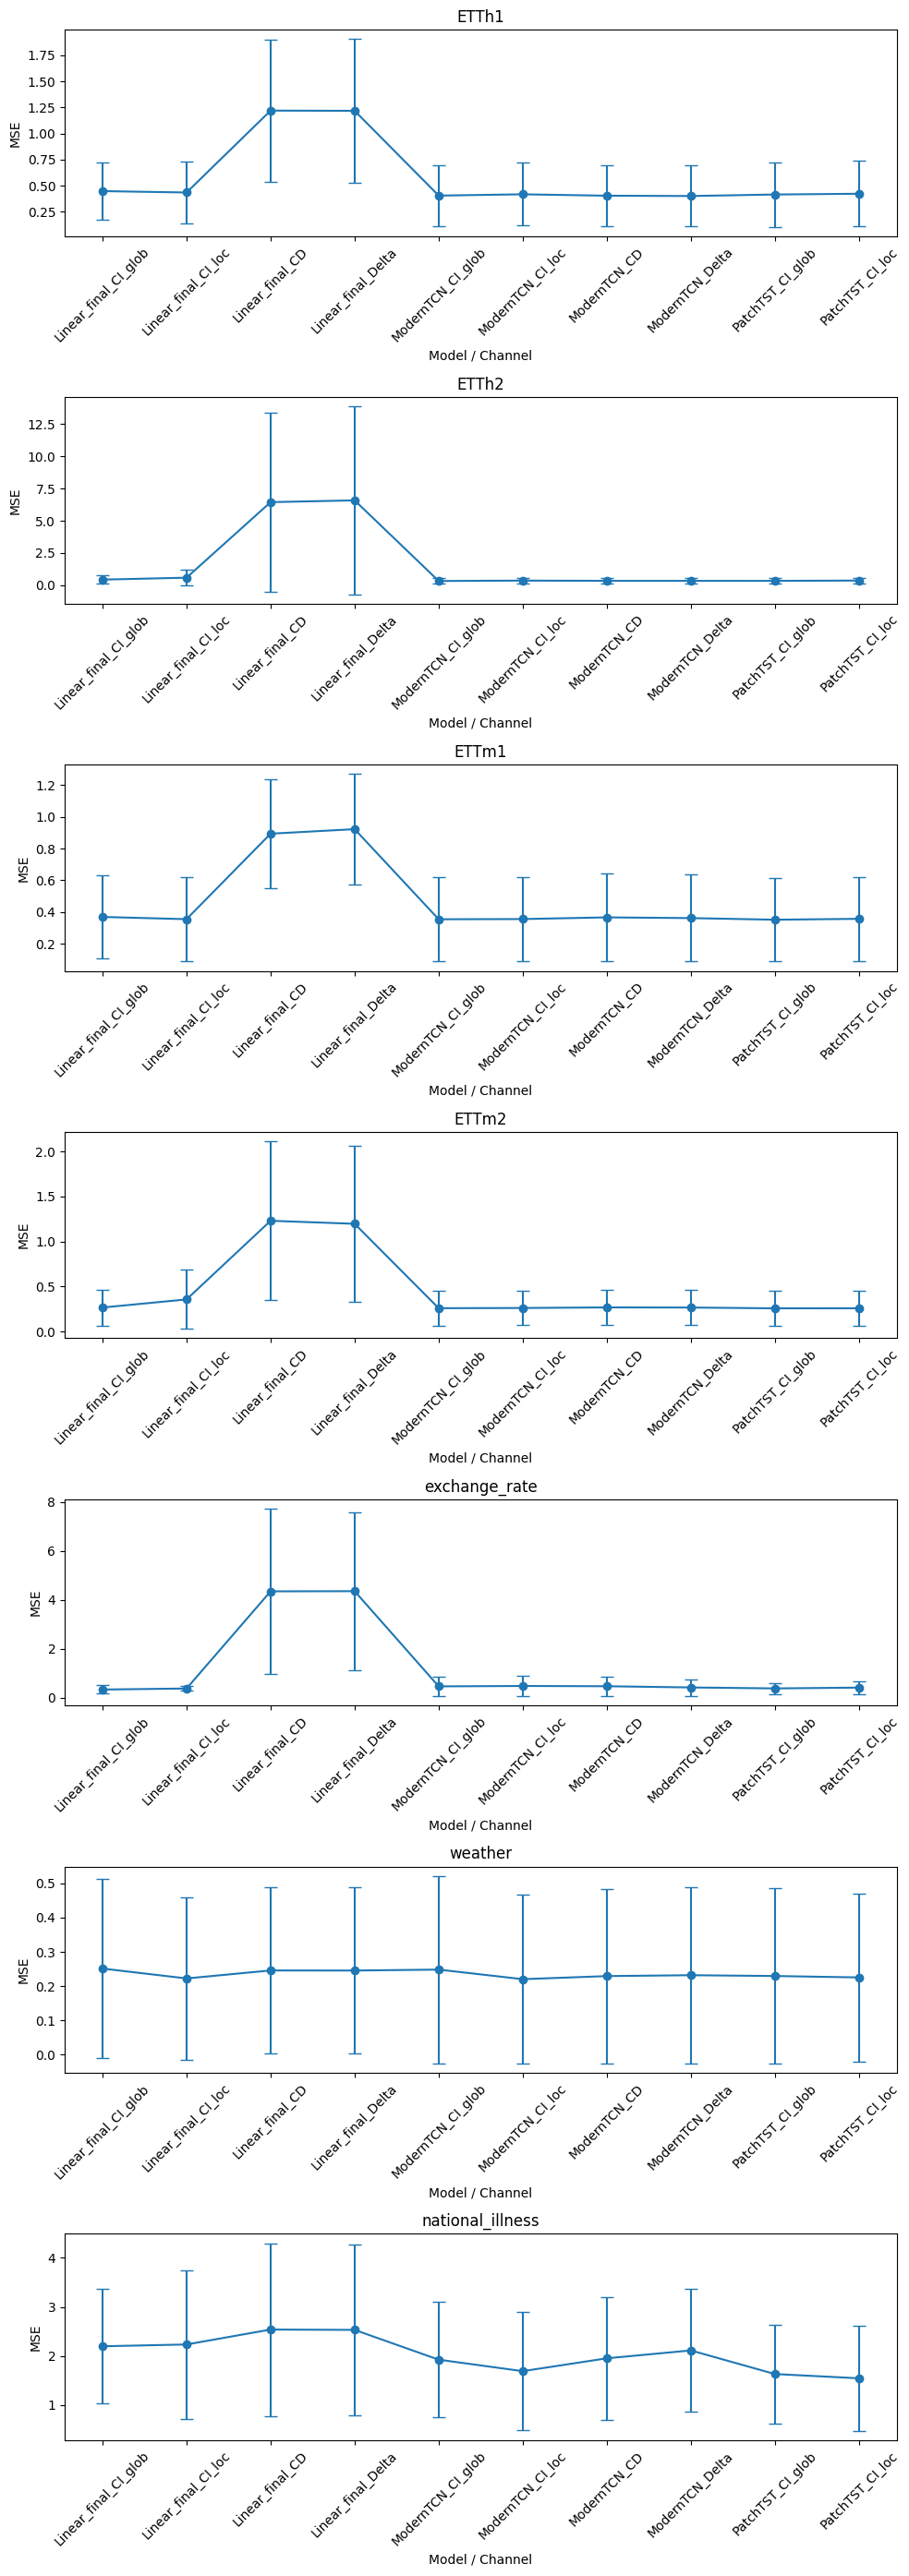

In [17]:

data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]

n = len(data_path_list)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)  # single column, multiple rows

for idx, data_path in enumerate(data_path_list):
    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["data_path"] == data_path) &
                     (df_avg["cd_weight_decay"] == 0.0)].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue

    x = df_plot['model_CH']
    y = df_plot['mse']
    yerr = df_plot['mse_per_channel_std']

    ax.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, linestyle='-', marker='o')
    ax.set_title(data_path)
    ax.set_xlabel('Model / Channel')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/Other/models_errorbar.png")
plt.show()


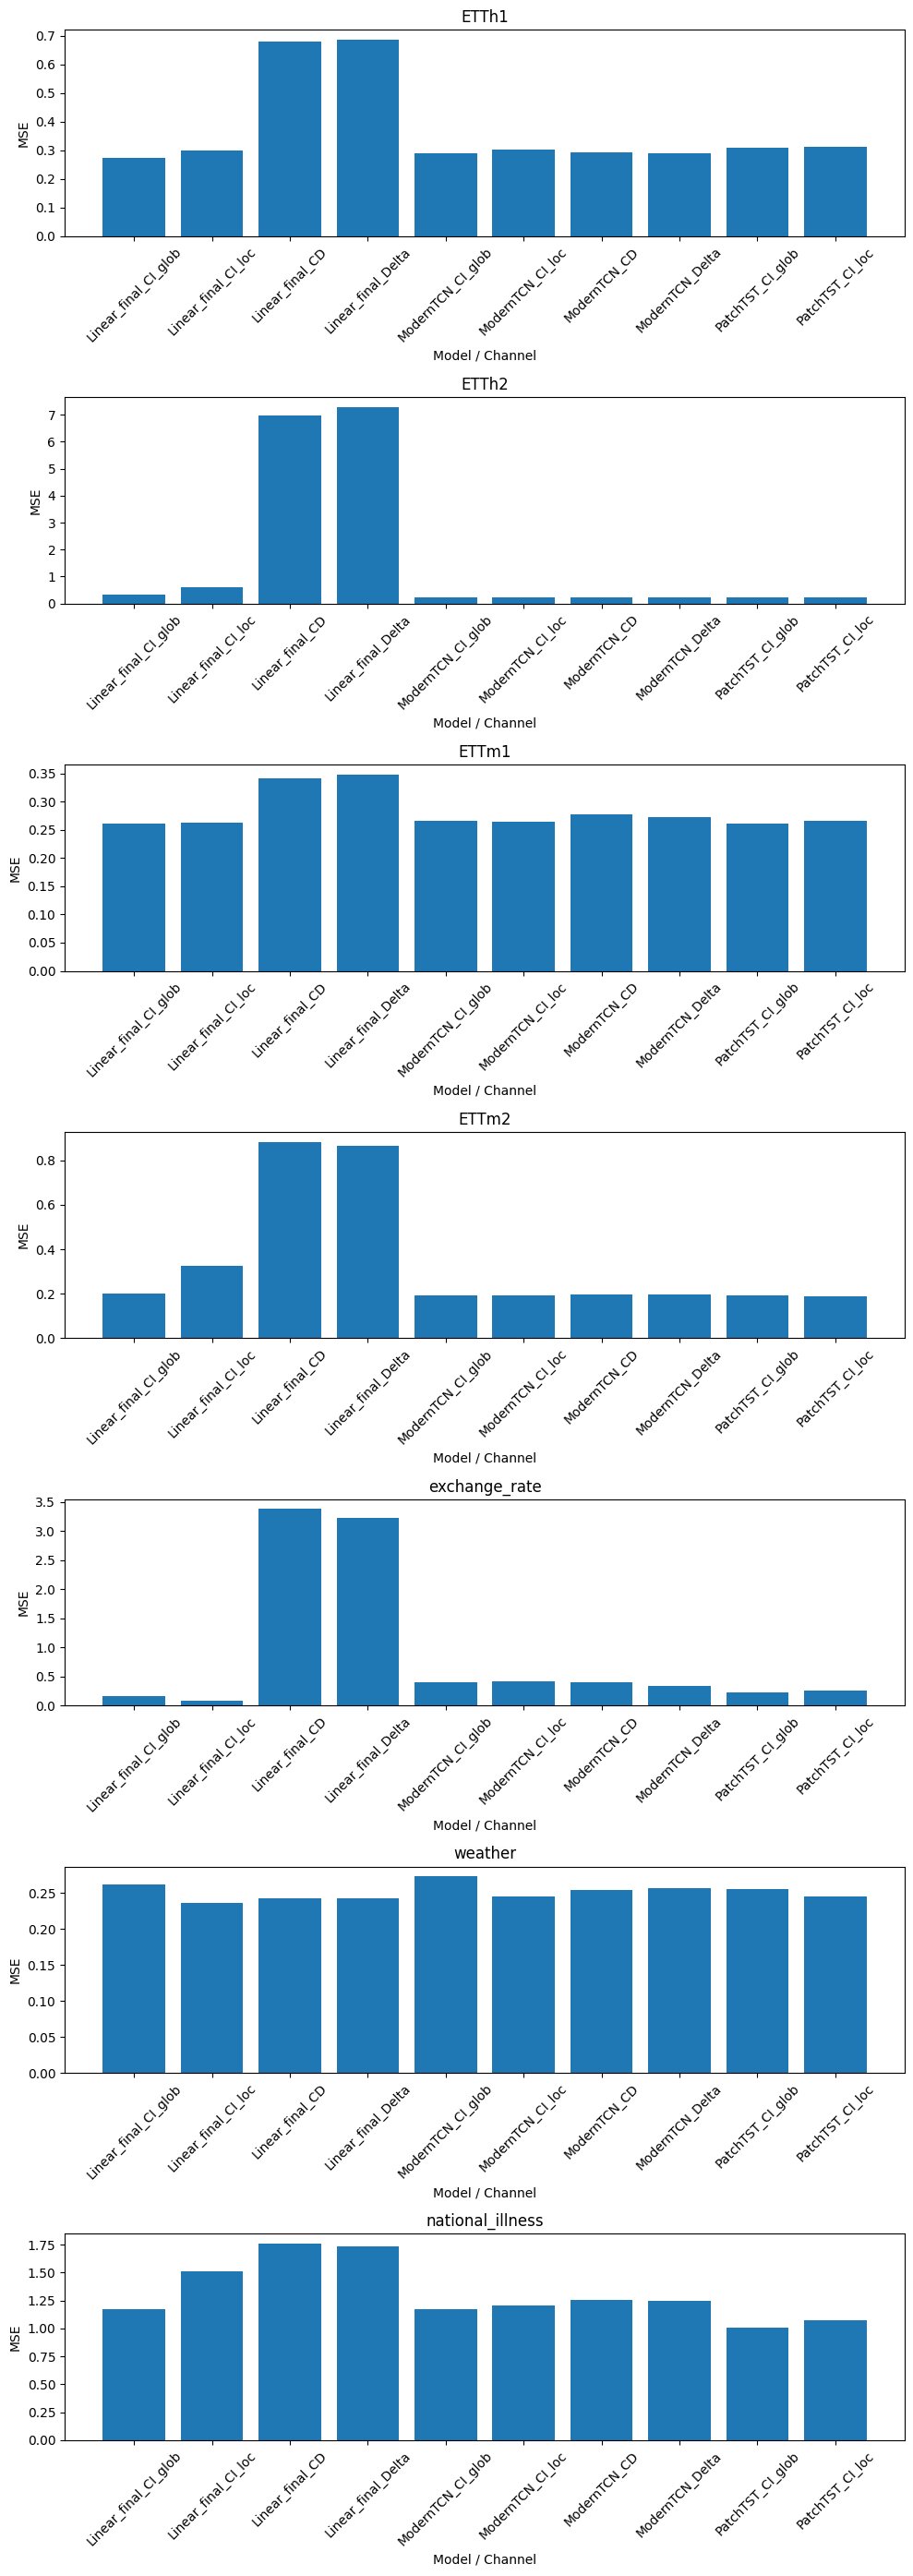

In [18]:

data_path_list = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "national_illness"]

n = len(data_path_list)
fig, axes = plt.subplots(n, 1, figsize=(10, 4 * n), squeeze=False)  # single column, multiple rows

for idx, data_path in enumerate(data_path_list):
    ax = axes[idx][0]

    df_plot = df_avg[(df_avg["data_path"] == data_path) &
                     (df_avg["cd_weight_decay"] == 0.0)].copy()

    if df_plot.empty:
        ax.set_title(f"{data_path} (no data)")
        ax.axis("off")
        continue

    x = df_plot['model_CH']
    y = df_plot['mse']
    yerr = df_plot['mse_per_channel_std']

    ax.bar(x, yerr)
    ax.set_title(data_path)
    ax.set_xlabel('Model / Channel')
    ax.set_ylabel('MSE')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("plots/Other/models_std.png")
plt.show()


## Table

In [19]:


def table(channel_handling = "CI_glob", df_avg=df_avg, df_subset=df_subset):
    list_pred_len = [96, 192, 336, 720, "Avg"]
    list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity"]
    index_labels = [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    list_pred_len = [24, 36, 48, 60, "Avg"]
    list_data_path = ["national_illness"]
    index_labels = index_labels + [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    # Example: define some columns
    columns = [f"{model} - {metric}" for model in ["Linear_final", "ModernTCN", "PatchTST"] for metric in ["MSE", "MAE"]]

    df_table = pd.DataFrame(index=index_labels, columns=columns)

    for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "exchange_rate", "weather", "traffic", "electricity", "national_illness"]:
        if data_path == "national_illness":
            list_pred_len = [24, 36, 48, 60, "Avg"]
        else:
            list_pred_len = [96, 192, 336, 720, "Avg"]

        for pred_len in list_pred_len:
            for model in ["Linear_final", "ModernTCN", "PatchTST"]:
                if pred_len == "Avg":
                    df_filtered = df_avg[
                        (df_avg['data_path'].str.contains(data_path)) &
                        (df_avg['model'] == model) &
                        (df_avg['channel_handling'] == channel_handling)
                    ]
                else:
                    df_filtered = df_subset[
                        (df_subset['data_path'].str.contains(data_path)) &
                        (df_subset['pred_len'] == pred_len) &
                        (df_subset['model'] == model) &
                        (df_subset['channel_handling'] == channel_handling)
                    ]
                    #display(df_filtered)

                if not df_filtered.empty:
                    mse = df_filtered['mse'].values[0]
                    mae = df_filtered['mae'].values[0]
                    df_table.loc[f"{data_path} - {pred_len}", f"{model} - MSE"] = round(mse, 3)
                    df_table.loc[f"{data_path} - {pred_len}", f"{model} - MAE"] = round(mae, 3)

    return df_table

def render_table(df, title="", fontsize=10, show:bool=False):
    fig, ax = plt.subplots(figsize=(len(df.columns)*1.8, len(df)*0.3))  # Adjust figure size
    ax.axis('off')  # Hide axes

    table = plt.table(
        cellText=df.values,
        rowLabels=df.index,
        colLabels=df.columns,
        cellLoc='center',
        loc='center'
    )

    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)
    table.scale(1.2, 1.2)  # Adjust scaling for better readability

    if title:
        plt.title(title, fontsize=fontsize+2)

    save_dir = f"plots/tables"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/{channel_handling}.png"
    plt.savefig(save_path)

    plt.tight_layout()
    
    if show:
        plt.show()
    else:
        plt.close(fig)

#render_table(table(), title="Results for CI_glob Channel Handling", fontsize=10);

In [20]:
vf.render_table(vf.table(channel_handling="CI_glob", df_avg=df_avg, df_subset=df_subset), title="Results for CI_glob", fontsize=10)

## Comp (PatchTST, ModernTCN)

In [21]:


def comp_PatchTST(df_avg=df_avg, df_subset=df_subset):
    list_pred_len = [96, 192, 336, 720, "Avg"]
    list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "traffic", "electricity"]      # , "exchange_rate"
    index_labels = [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    list_pred_len = [24, 36, 48, 60, "Avg"]
    list_data_path = ["national_illness"]
    index_labels = index_labels + [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    model = "PatchTST"
    channel_handling = "CI_glob"
    columns = ["MSE - sk", "MSE - paper", "MSE - %", "MAE - sk", "MAE - paper", "MAE - %"]
    # ref PatchTST/42

    df_table = pd.DataFrame(index=index_labels, columns=columns)

    for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "traffic", "electricity", "national_illness"]:     # "exchange_rate" isn't evaluated in the paper
        if data_path == "national_illness":
            list_pred_len = [24, 36, 48, 60, "Avg"]
        else:
            list_pred_len = [96, 192, 336, 720, "Avg"]

        for pred_len in list_pred_len:
            if pred_len == "Avg":
                df_filtered = df_avg[
                    (df_avg['data_path'].str.contains(data_path)) &
                    (df_avg['model'] == model) &
                    (df_avg['channel_handling'] == channel_handling)
                ]
            else:
                df_filtered = df_subset[
                    (df_subset['data_path'].str.contains(data_path)) &
                    (df_subset['pred_len'] == pred_len) &
                    (df_subset['model'] == model) &
                    (df_subset['channel_handling'] == channel_handling)
                ]

            if not df_filtered.empty:
                mse = df_filtered['mse'].values[0]
                mae = df_filtered['mae'].values[0]
                df_table.loc[f"{data_path} - {pred_len}", f"MSE - sk"] = round(mse, 3)
                df_table.loc[f"{data_path} - {pred_len}", f"MAE - sk"] = round(mae, 3)

            
            mse = df_ref[
                (df_ref['data_path'].str.contains(data_path)) &
                (df_ref['pred_len'] == str(pred_len)) &
                (df_ref['model'] == "PatchTST/42")
            ]['mse'].values[0]
            mae = df_ref[
                (df_ref['data_path'].str.contains(data_path)) &
                (df_ref['pred_len'] == str(pred_len)) &
                (df_ref['model'] == "PatchTST/42")
            ]['mae'].values[0]

            #print(f"Processing {data_path} - {pred_len}, MSE: {mse}, MAE: {mae}")


            df_table.loc[f"{data_path} - {pred_len}", f"MSE - paper"] = round(mse, 3)
            df_table.loc[f"{data_path} - {pred_len}", f"MAE - paper"] = round(mae, 3)   

            mse_perc = df_table.loc[f"{data_path} - {pred_len}", f"MSE - sk"] / df_table.loc[f"{data_path} - {pred_len}", f"MSE - paper"] - 1
            mae_perc = df_table.loc[f"{data_path} - {pred_len}", f"MAE - sk"] / df_table.loc[f"{data_path} - {pred_len}", f"MAE - paper"] - 1

            df_table.loc[f"{data_path} - {pred_len}", f"MSE - %"] = round(mse_perc * 100, 2)
            df_table.loc[f"{data_path} - {pred_len}", f"MAE - %"] = round(mae_perc * 100, 2)

    return df_table




def comp_ModernTCN(df_avg=df_avg, df_subset=df_subset):
    list_pred_len = [96, 192, 336, 720, "Avg"]
    list_data_path = ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "traffic", "electricity", "exchange_rate"]
    index_labels = [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    list_pred_len = [24, 36, 48, 60, "Avg"]
    list_data_path = ["national_illness"]
    index_labels = index_labels + [f"{data_path} - {pred_len}" for data_path in list_data_path for pred_len in list_pred_len]

    model = "ModernTCN"
    channel_handling = "CD"
    cd_weight_decay = 0.0
    columns = ["MSE - sk", "MSE - paper", "MSE - %", "MAE - sk", "MAE - paper", "MAE - %"]
    # ref PatchTST/42

    df_table = pd.DataFrame(index=index_labels, columns=columns)

    for data_path in ["ETTh1", "ETTh2", "ETTm1", "ETTm2", "weather", "traffic", "electricity", "national_illness", "exchange_rate"]:
        if data_path == "national_illness":
            list_pred_len = [24, 36, 48, 60, "Avg"]
        else:
            list_pred_len = [96, 192, 336, 720, "Avg"]

        for pred_len in list_pred_len:
            if pred_len == "Avg":
                df_filtered = df_avg[
                    (df_avg['data_path'].str.contains(data_path)) &
                    (df_avg['model'] == model) &
                    (df_avg['channel_handling'] == channel_handling) &
                    (df_avg['cd_weight_decay'] == cd_weight_decay)
                ]
            else:
                df_filtered = df_subset[
                    (df_subset['data_path'].str.contains(data_path)) &
                    (df_subset['pred_len'] == pred_len) &
                    (df_subset['model'] == model) &
                    (df_subset['channel_handling'] == channel_handling) &
                    (df_subset['cd_weight_decay'] == cd_weight_decay)
                ]

            if not df_filtered.empty:
                mse = df_filtered['mse'].values[0]
                mae = df_filtered['mae'].values[0]
                df_table.loc[f"{data_path} - {pred_len}", f"MSE - sk"] = round(mse, 3)
                df_table.loc[f"{data_path} - {pred_len}", f"MAE - sk"] = round(mae, 3)
            
            mse = df_ref[
                (df_ref['data_path'].str.contains(data_path)) &
                (df_ref['pred_len'] == str(pred_len)) &
                (df_ref['model'] == model)
            ]['mse'].values[0]
            mae = df_ref[
                (df_ref['data_path'].str.contains(data_path)) &
                (df_ref['pred_len'] == str(pred_len)) &
                (df_ref['model'] == model)
            ]['mae'].values[0]

            print(f"Processing {data_path} - {pred_len}, MSE: {mse}, MAE: {mae}")


            df_table.loc[f"{data_path} - {pred_len}", f"MSE - paper"] = round(mse, 3)
            df_table.loc[f"{data_path} - {pred_len}", f"MAE - paper"] = round(mae, 3)   

            mse_perc = df_table.loc[f"{data_path} - {pred_len}", f"MSE - sk"] / df_table.loc[f"{data_path} - {pred_len}", f"MSE - paper"] - 1
            mae_perc = df_table.loc[f"{data_path} - {pred_len}", f"MAE - sk"] / df_table.loc[f"{data_path} - {pred_len}", f"MAE - paper"] - 1

            df_table.loc[f"{data_path} - {pred_len}", f"MSE - %"] = round(mse_perc * 100, 2)
            df_table.loc[f"{data_path} - {pred_len}", f"MAE - %"] = round(mae_perc * 100, 2)

    return df_table

In [22]:
vf.render_table(comp_PatchTST(df_avg=df_avg, df_subset=df_subset), title="PatchTST_Comp", fontsize=10)
vf.render_table(comp_ModernTCN(df_avg=df_avg, df_subset=df_subset), title="ModernTCN_Comp", fontsize=10)

Processing ETTh1 - 96, MSE: 0.368, MAE: 0.394
Processing ETTh1 - 192, MSE: 0.405, MAE: 0.413
Processing ETTh1 - 336, MSE: 0.391, MAE: 0.412
Processing ETTh1 - 720, MSE: 0.45, MAE: 0.461
Processing ETTh1 - Avg, MSE: 0.404, MAE: 0.42
Processing ETTh2 - 96, MSE: 0.263, MAE: 0.332
Processing ETTh2 - 192, MSE: 0.32, MAE: 0.374
Processing ETTh2 - 336, MSE: 0.313, MAE: 0.376
Processing ETTh2 - 720, MSE: 0.392, MAE: 0.433
Processing ETTh2 - Avg, MSE: 0.322, MAE: 0.379
Processing ETTm1 - 96, MSE: 0.292, MAE: 0.346
Processing ETTm1 - 192, MSE: 0.332, MAE: 0.368
Processing ETTm1 - 336, MSE: 0.365, MAE: 0.391
Processing ETTm1 - 720, MSE: 0.416, MAE: 0.417
Processing ETTm1 - Avg, MSE: 0.351, MAE: 0.381
Processing ETTm2 - 96, MSE: 0.166, MAE: 0.256
Processing ETTm2 - 192, MSE: 0.222, MAE: 0.293
Processing ETTm2 - 336, MSE: 0.272, MAE: 0.324
Processing ETTm2 - 720, MSE: 0.351, MAE: 0.381
Processing ETTm2 - Avg, MSE: 0.253, MAE: 0.314
Processing weather - 96, MSE: 0.149, MAE: 0.2
Processing weather - 

In [23]:
# CI_glob, CI_loc, CD, Delta (letzte beide inkl. cd_weight_decay)
# versch. random seeds

# versch. lags & pred_len

data_path_list = "_weather_shower_lag"

cd_weight_decay = 0.0
random_seed = 2021

df_subset[df_subset['data_path'].str.contains(data_path)]

,model,pred_len,random_seed,data_path,mae,mse,seq_len,cd_weight_decay,mse_train,mae_train,...,mae_train_per_channel_list,mae_per_channel_list,channel_handling,learning_rate,batch_size,patience,head_dropout,dropout,delta_factor,skip_1st_epoch
543,PatchTST,24,2021,national_illness,0.803709,1.526970,104,0.0,0.178466,0.266468,...,"[0.323392391204834, 0.3177845776081085, 0.2902...","[0.5129213929176331, 0.6478416323661804, 1.175...",CI_loc,0.0025,16,20,0.0,0.30,1.0,0.0
546,PatchTST,24,2021,national_illness,0.734400,1.300964,104,0.0,0.147548,0.268095,...,"[0.32734137773513794, 0.3444662392139435, 0.26...","[0.48295941948890686, 0.5699107646942139, 0.94...",CI_glob,0.0025,16,20,0.0,0.30,1.0,0.0
549,PatchTST,36,2021,national_illness,0.738304,1.402446,104,0.0,0.139886,0.241957,...,"[0.2924741208553314, 0.275689035654068, 0.2251...","[0.4654504358768463, 0.5817347168922424, 1.171...",CI_loc,0.0025,16,20,0.0,0.30,1.0,0.0
553,PatchTST,36,2021,national_illness,0.897628,1.658348,104,0.0,0.301664,0.343836,...,"[0.3963671922683716, 0.40513041615486145, 0.34...","[0.6038227677345276, 0.698068380355835, 1.0487...",CI_glob,0.0025,16,20,0.0,0.30,1.0,0.0
556,PatchTST,48,2021,national_illness,0.781294,1.551446,104,0.0,0.108178,0.218677,...,"[0.27350935339927673, 0.2145286351442337, 0.19...","[0.499705582857132, 0.5648725032806396, 1.1448...",CI_loc,0.0025,16,20,0.0,0.30,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6853,Linear_final,60,2025,national_illness,1.125286,2.761027,104,0.1,0.193905,0.261825,...,"[0.3064042329788208, 0.3258795142173767, 0.242...","[0.9506398439407348, 1.0250247716903689, 1.384...",Delta,0.0050,32,20,0.0,0.05,1.0,1.0
6854,Linear_final,24,2025,national_illness,0.966875,2.104870,104,1.0,0.175310,0.250610,...,"[0.29654061794281006, 0.31647565960884094, 0.2...","[0.8080660700798035, 0.8735821843147278, 1.255...",Delta,0.0050,32,20,0.0,0.05,1.0,1.0
6856,Linear_final,36,2025,national_illness,0.969060,2.214893,104,1.0,0.183034,0.245036,...,"[0.2896304428577423, 0.3084365129470825, 0.231...","[0.8055736422538757, 0.8829195499420166, 1.210...",Delta,0.0050,32,20,0.0,0.05,1.0,1.0
6857,Linear_final,48,2025,national_illness,1.002569,2.354463,104,1.0,0.240188,0.294305,...,"[0.34254977107048035, 0.36091795563697815, 0.2...","[0.7949936389923096, 0.8712086081504822, 1.262...",Delta,0.0050,32,20,0.0,0.05,1.0,1.0


In [24]:
pred_len_list = 96
data_path_list = ["_weather_shower_lag"]


def lag(pred_len=pred_len, data_path_list=data_path_list, df_subset=df_subset, model="Linear_final"):
    fig, axs = plt.subplots(4, figsize=(10, 10), sharey=True)
    #fig, axs = plt.subplots(4, figsize=(10, 10))#, sharey=True)

    
    for j, data_path in enumerate(data_path_list):
        for ind, channel_handling in enumerate(["CI_glob", "CI_loc", "CD", "Delta"]):
            df_CI = df_subset[(df_subset['model'] == model) & (df_subset['channel_handling'] == channel_handling) & (df_subset['cd_weight_decay'] == 0.0) & (df_subset['random_seed'] == 2021) 
                              & (df_subset['data_path'].str.contains(data_path)) & (df_subset['pred_len'] == pred_len) & (df_subset['patience'] == 20)].copy()
            #df_CI['data_lag'] = df_CI['data_path'].str.extract(r'_([0-9]+)$').astype(int)
            df_CI['data_lag'] = df_CI['data_path'].str.extract(r'_lag_([0-9]+)')[0].astype(int)
            df_CI = df_CI.sort_values(by='data_lag')

            #display(df_CI)

            data_train = df_CI["mse_train_per_channel_list"].tolist()
            data_test = df_CI["mse_per_channel_list"].tolist()
            combined = [d1 + d2 for d1, d2 in zip(data_train, data_test)]
            
            data = list(map(list, zip(*combined)))        # "Transpose" the list of lists
            #display(data)

            x_labels = df_CI['data_lag'].astype(str).tolist()
            
            #group_labels = ['NoLag_train', 'Lag_train', 'NoLag_test', 'Lag_test']
            group_labels = ['NoLag_train', 'Lag_train', 'NoLag_test', 'Lag_test']

            bar_width = 0.15
            x = np.arange(len(x_labels))

            # Plot using a loop
            for l, group in enumerate(data):
                offset = (l - len(data)/2 + 0.5) * bar_width
                axs[ind].bar(x + offset, group, width=bar_width, label=group_labels[l])

            axs[ind].set_xticks(x)
            axs[ind].set_xticklabels(x_labels)
            axs[ind].set_title(f'{model} - {channel_handling} - Pred Len: {pred_len}, Data: {data_path}')
            axs[ind].set_ylabel(metric)
            axs[ind].set_xlabel("Data lag")
            axs[ind].legend()
            axs[ind].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("plots/Dataset_Selec/"+model+"_pred"+str(pred_len)+".png")
    #plt.show()

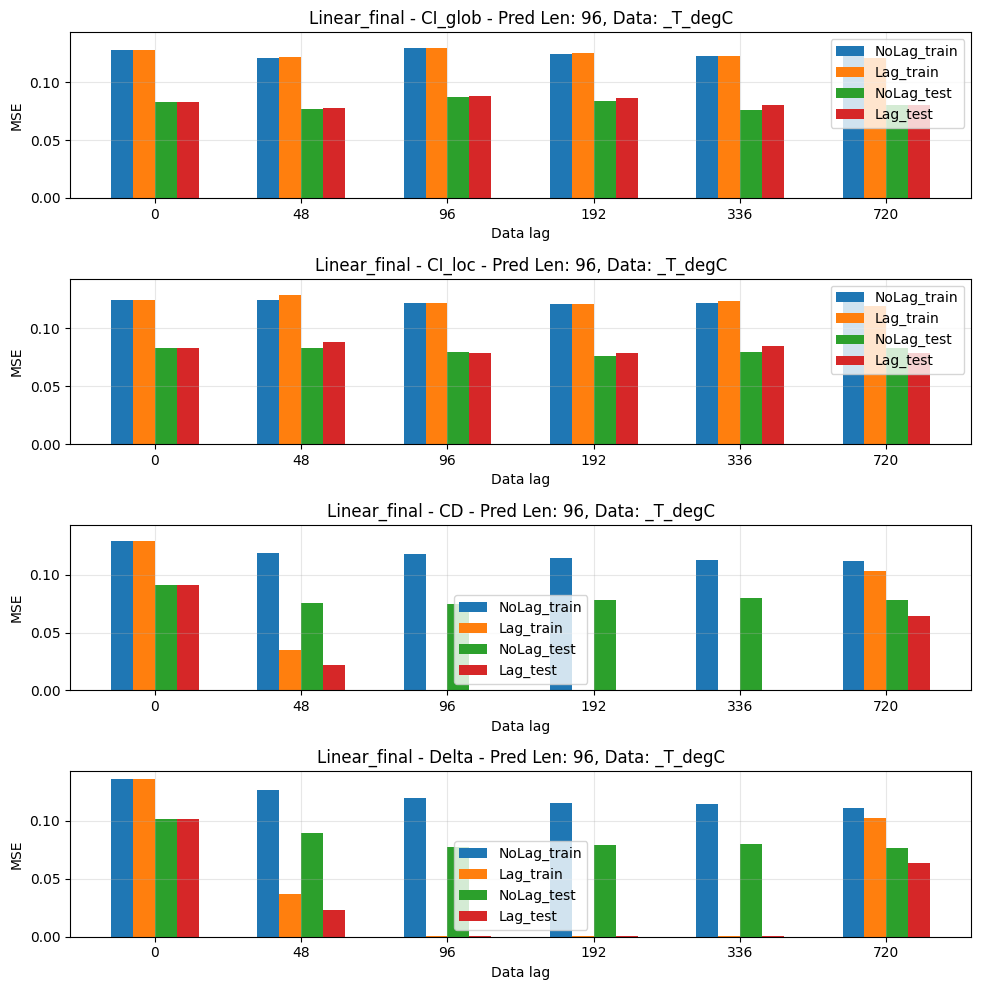

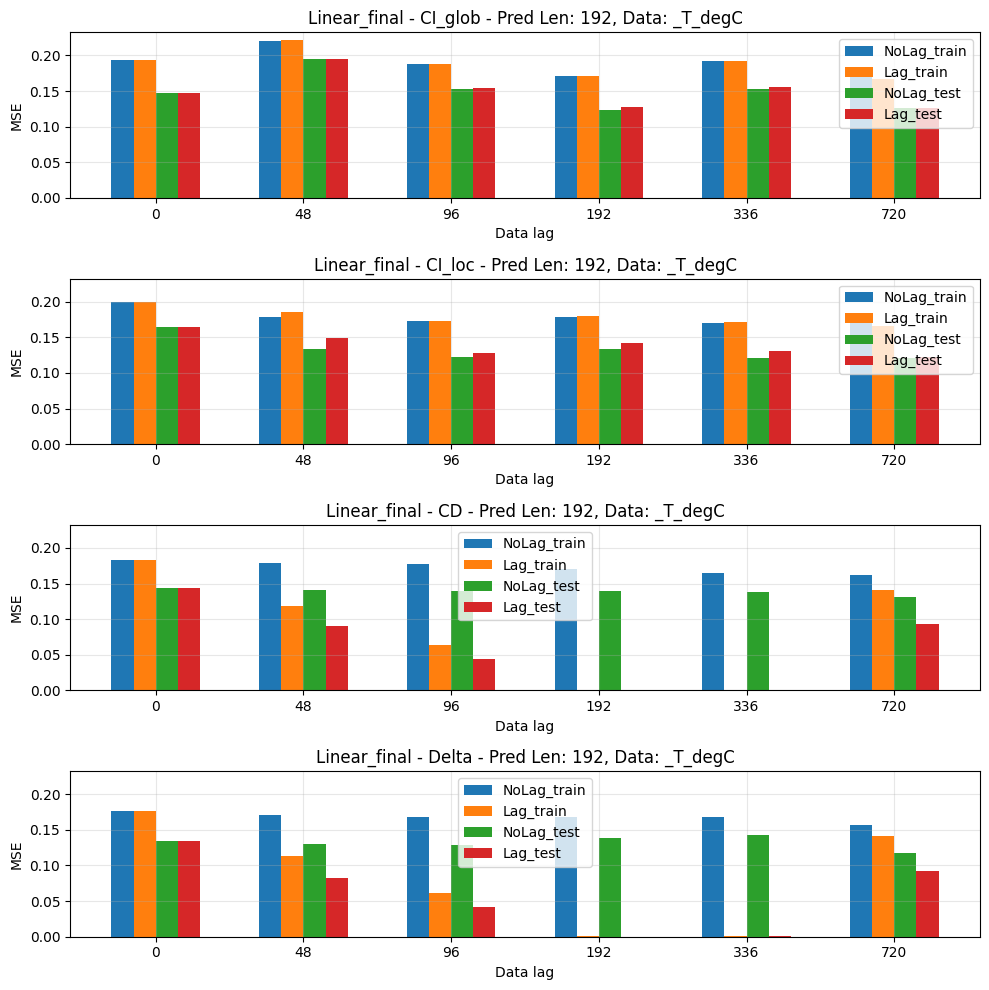

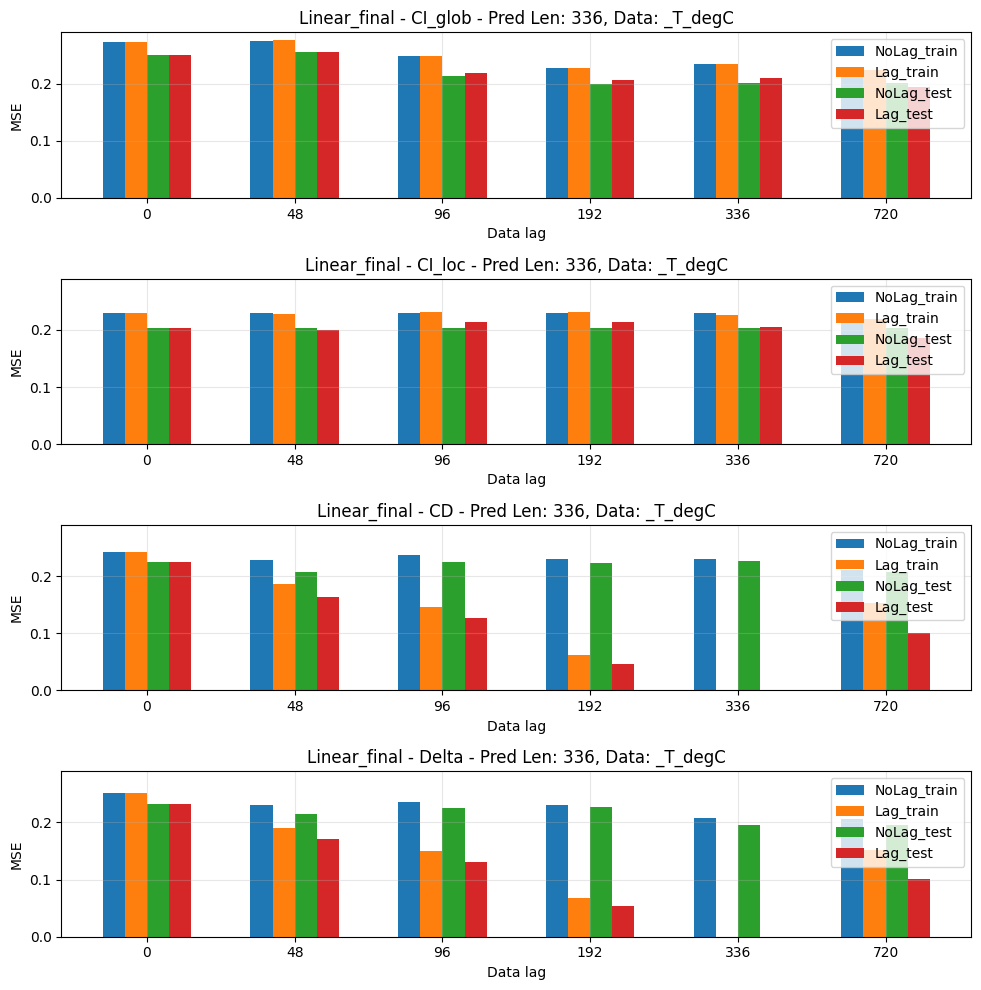

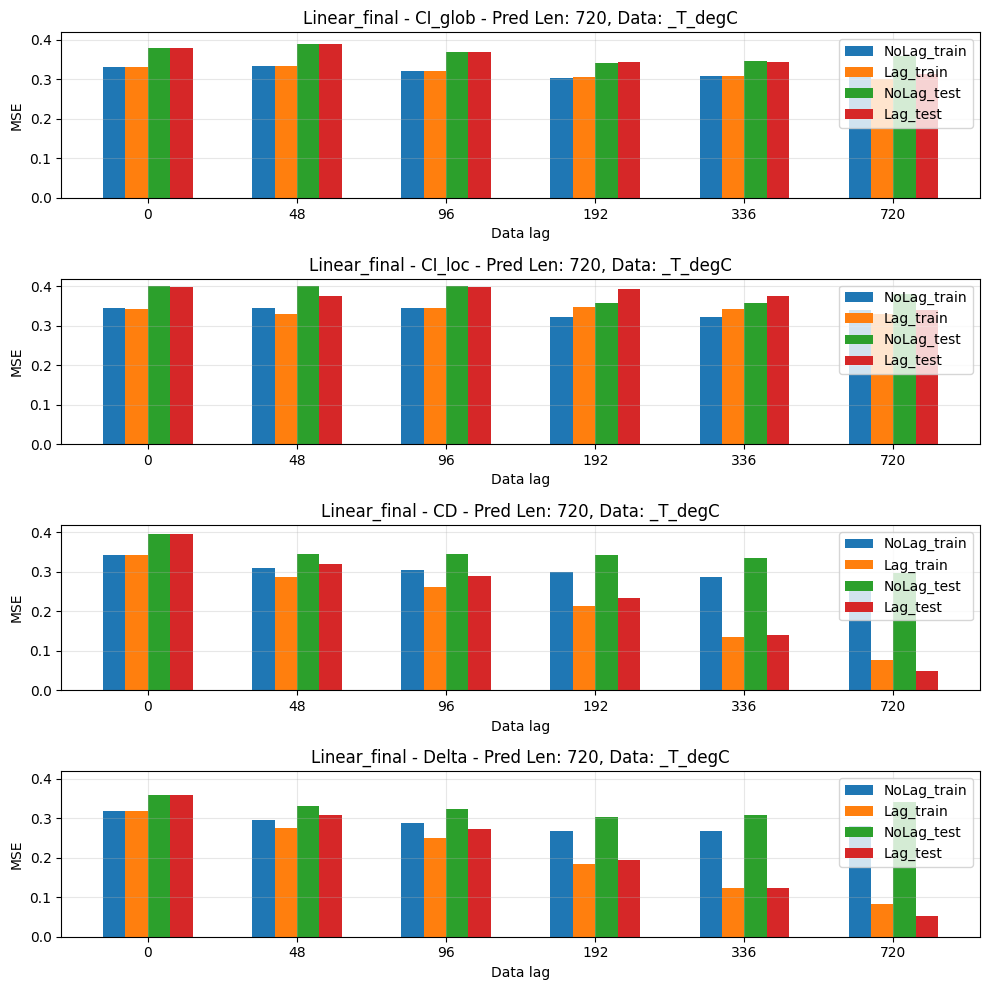

In [26]:
metric = "MSE"

for pred_len in [96, 192, 336, 720]:
    lag(model="Linear_final", data_path_list=["_T_degC"], pred_len=pred_len)

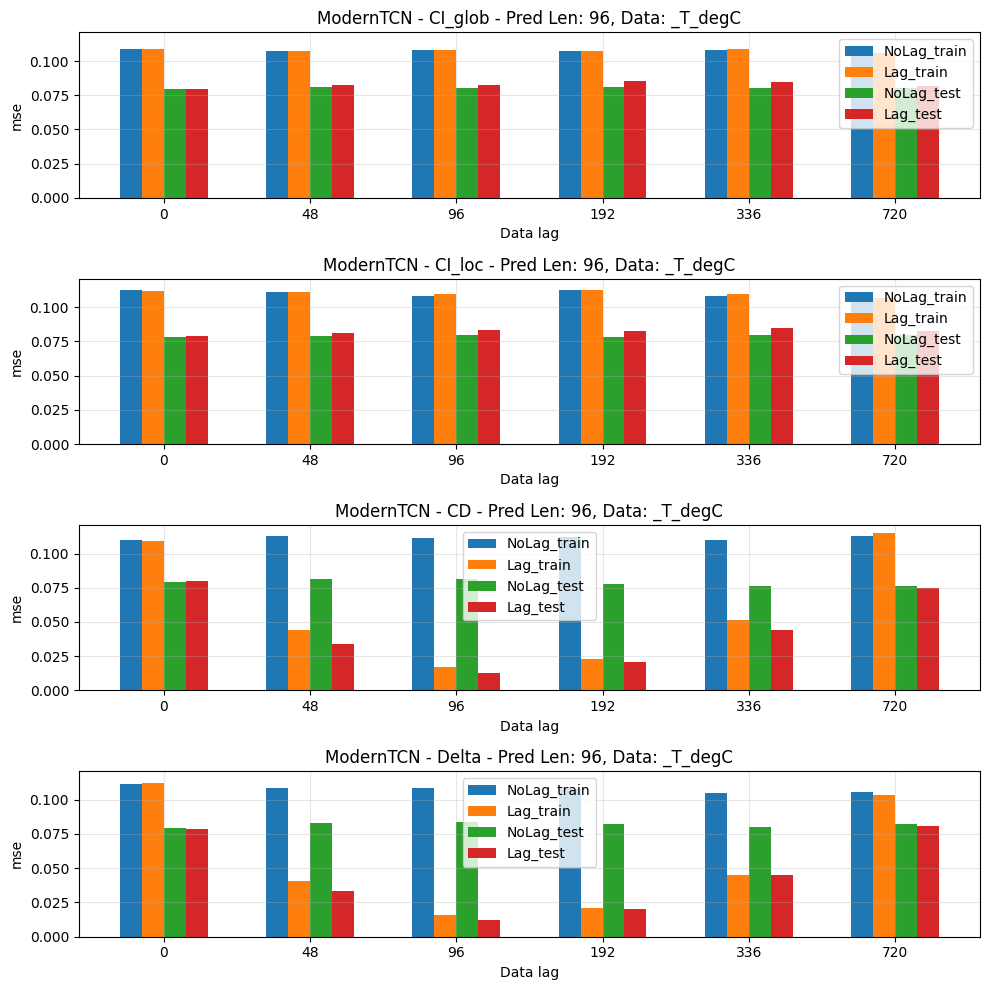

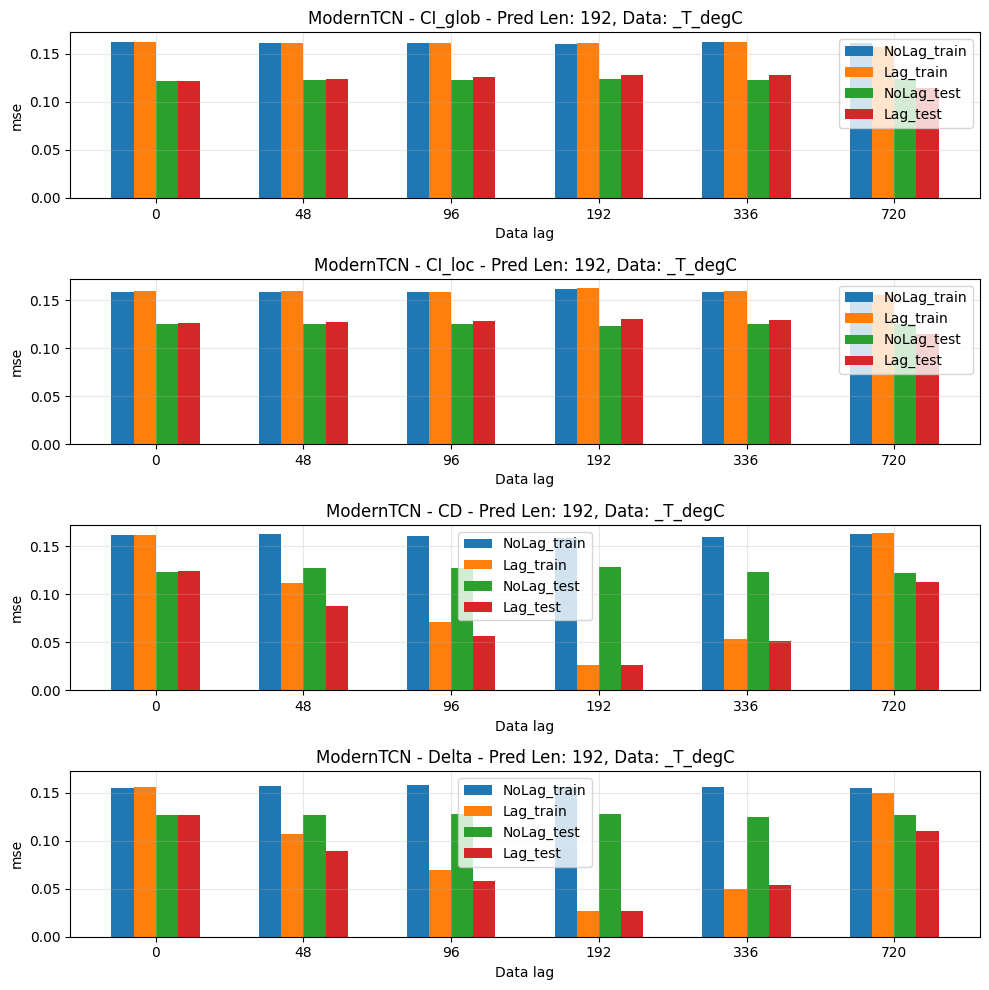

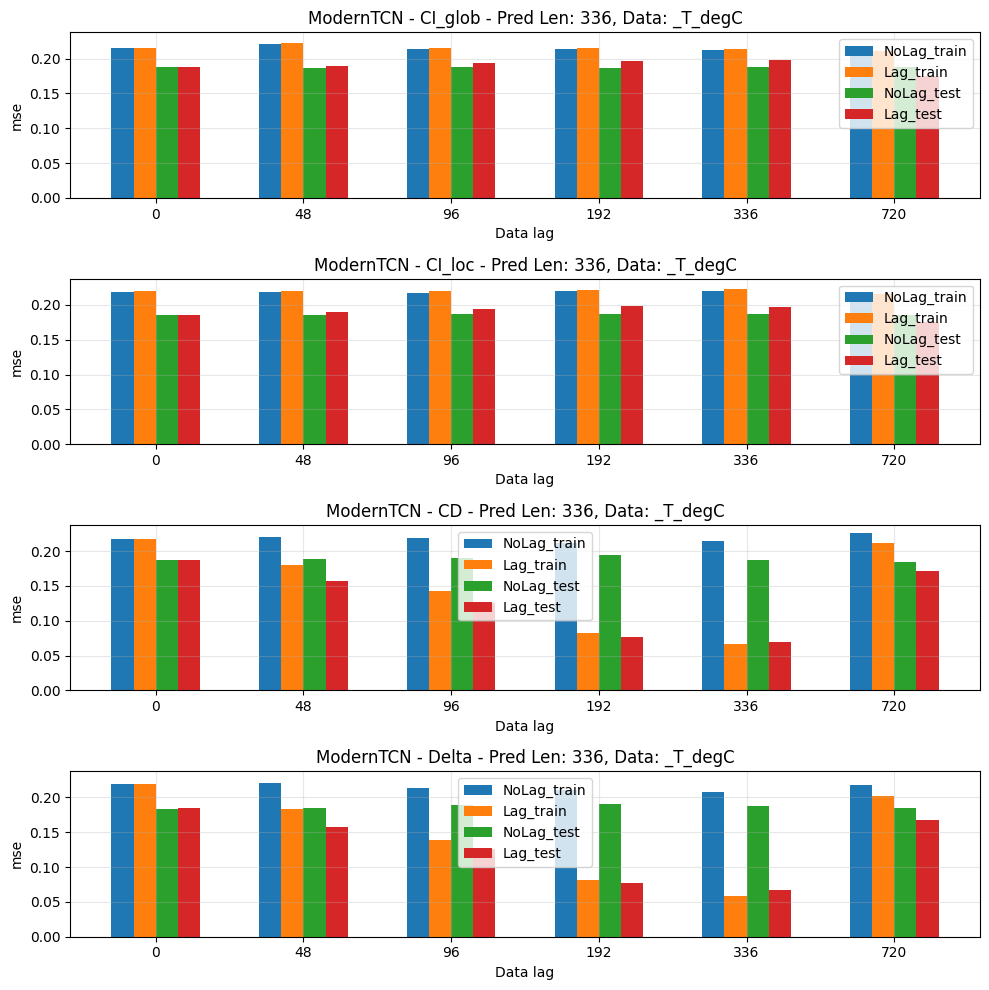

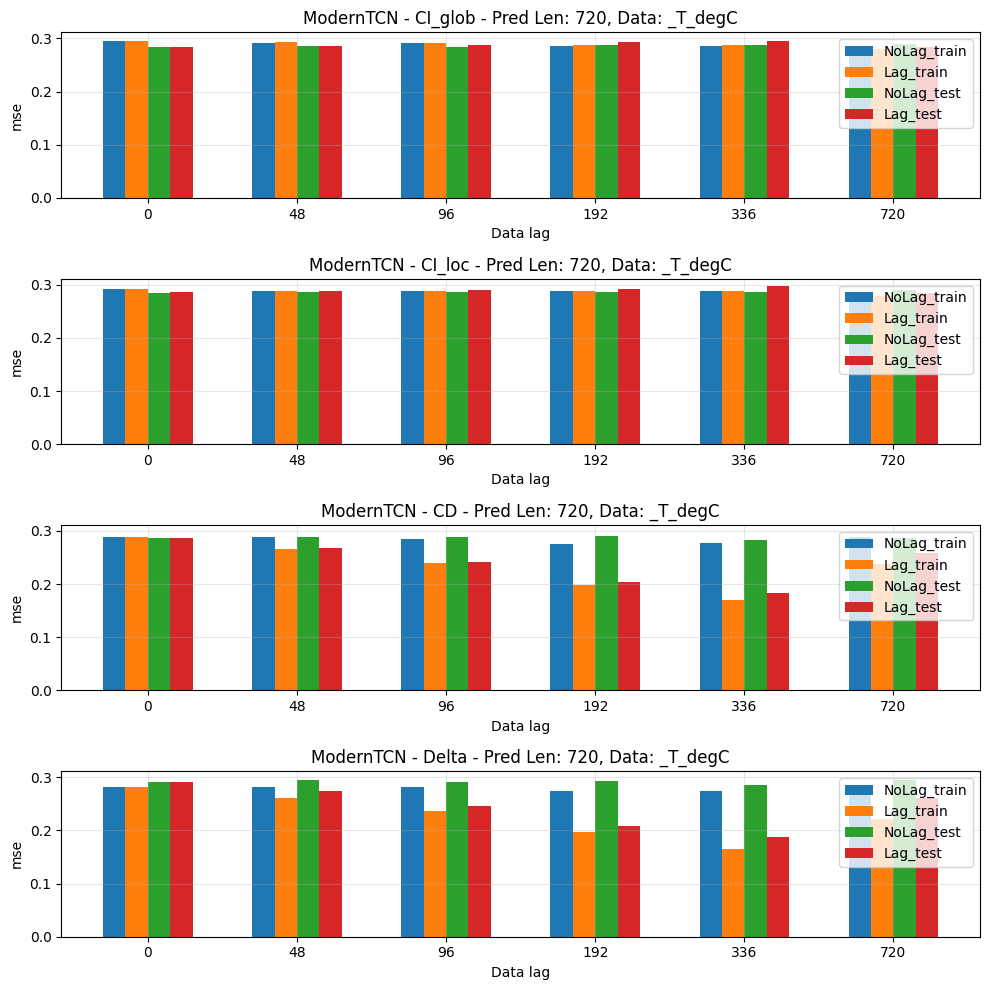

In [ ]:
for pred_len in [96, 192, 336, 720]:
    lag(model="ModernTCN", data_path_list=["_T_degC"], pred_len=pred_len)

In [ ]:
base_path = "/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/PatchTST/PatchTST_supervised/checkpoints"

matches = [
    folder for folder in os.listdir(base_path)
    if os.path.isdir(os.path.join(base_path, folder)) and
       #all(key in folder for key in ["TCN", "720", "raffic", "CD"])
       all(key in folder for key in ["TCN", "raffic"])
       #all(key in folder for key in ["TCN", "lectricity"])
]

matches.sort()

for match in matches:
    print(match)

Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_Exp_0
Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCI_glob_cdwd0.0_Exp_0
Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chDelta_cdwd0.0_Exp_0
Traffic_336_192_ModernTCN_custom_ftM_sl336_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chDelta_cdwd0.0_df0.5_Exp_0
Traffic_336_336_ModernTCN_custom_ftM_sl336_ll48_pl336_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_Exp_0
Traffic_336_336_ModernTCN_custom_ftM_sl336_ll48_pl336_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCI_glob_cdwd0.0_Exp_0
Traffic_336_336_ModernTCN_custom_ftM_sl336_ll48_pl336_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCI_glob_cdwd0.0_df1.0_Exp_0
Traffic_336_720_ModernTCN_custom_ftM_sl336_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_r

In [ ]:
import os
import json

base = "/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/PatchTST/PatchTST_supervised/results/"
target = "electricity_336_720_ModernTCN_custom_ftM_sl336_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_Exp_0/"
target_path = os.path.join(base, target)

file_list = [
    "mse_train_per_channel_list.json",
    "mse_per_channel_list.json",
    "mae_train_per_channel_list.json",
    "mae_per_channel_list.json"
]

for filename in file_list:
    file_path = os.path.join(target_path, filename)
    print(f"\n--- {filename} ---")
    try:
        with open(file_path, "r") as f:
            data = json.load(f)
            print(data)
    except Exception as e:
        print(f"Error reading {filename}: {e}")



--- mse_train_per_channel_list.json ---
Error reading mse_train_per_channel_list.json: [Errno 2] No such file or directory: '/pfs/work9/workspace/scratch/ma_skral-SK_thesis_2025/Thesis_MTSF/PatchTST/PatchTST_supervised/results/electricity_336_720_ModernTCN_custom_ftM_sl336_ll48_pl720_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_rs2021_chCD_cdwd0.0_Exp_0/mse_train_per_channel_list.json'

--- mse_per_channel_list.json ---
[1.1540082693099976, 0.2644135653972626, 0.0002177944261347875, 0.15270425379276276, 0.3910791575908661, 0.14768019318580627, 1.2058324813842773, 0.16533857583999634, 0.27161818742752075, 0.603560745716095, 0.19879291951656342, 0.26834622025489807, 0.13946282863616943, 0.21940186619758606, 0.11976084858179092, 0.3142140507698059, 0.2500108778476715, 0.5309024453163147, 0.10304577648639679, 0.5235851407051086, 0.27337250113487244, 0.21309657394886017, 0.13580486178398132, 0.24508506059646606, 0.19141671061515808, 0.4933299422264099, 0.14371448755264282, 0.293767809867858